# Analisis & Prediksi Gempa Bumi Indonesia 2020–2025
---

# Introduction

Nama : Nindia Ekasuci Larasati

Batch : Hck - 030

## Gambaran Dataset

Dataset berisi catatan kejadian gempa bumi dengan informasi utama:

- **Waktu & lokasi**: `time`, `latitude`, `longitude`, `place`
- **Parameter seismik**: `depth` (km), `mag` (magnitude), `magType`, `nst`, `gap`, `dmin`, `rms`
- **Akurasi & sumber data**: `horizontalError`, `depthError`, `magError`, `magNst`, `status`, `locationSource`, `magSource`, `updated`
- **Identitas kejadian**: `id`, `net`, `type`

**Target (y)**: `mag` → Magnitude gempa bumi (numerik)  

---

## Objective

Menurut laporan [Badan Geologi](https://www.cnbcindonesia.com/news/20250122174037-4-605239/gempa-bumi-merusak-hantam-ri-cetak-rekor-di-2024-fakta-aneh-terungkap), kejadian gempa bumi yang telah mengakibatkan terjadinya korban jiwa, kerusakan bangunan, kerusakan lingkungan dan kerugian harta benda. Kejadian gempa bumi merusak tahun 2024 merupakan yang tertinggi dalam kurun waktu 24 tahun terakhir sejak tahun 2000. 

Memprediksi magnitudo gempa bumi menggunakan parameter lokasi, kedalaman, jumlah stasiun seismik, dan indikator akurasi menggunakan data gempa pada tahun 2020- 2025.  
                
Tujuannya adalah mendukung BNPB dalam memperkirakan kekuatan gempa lebih cepat sehingga dapat mengoptimalkan penyaluran sumber daya dan evakuasi.

---
## Algoritma 
Menggunakan algoritma :
1. KNN (K-Nearest Neighbor)
2. SVM (Support Vector Machines)
3. Decission Tree
4. Random Forest
5. Boosting

## Metrik Evaluasi

Menggunakan **Mean Absolute Error (MAE)** karena:

- Mengukur rata-rata selisih absolut antara prediksi dan nilai sebenarnya.
- Satuan hasil sama dengan magnitude, sehingga mudah diinterpretasikan.
- Tidak terlalu sensitif terhadap outlier dibandingkan MSE.

Berdasarkan hasil studi *EEW* dan *CNN*   
| Kategori MAE  | Interpretasi                                                               |
| ------------- | -------------------------------------------------------------------------- |
| **< 0.3**     | Sangat baik                  |
| **0.3 – 0.5** | Cukup baik         |
| **> 0.5**     | Kurang ideal  |

yang kemudian dilakukan cross validation untuk memilih 1 model utama yang terbaik diantara kelima algoritma untuk selanjutnya dilakukan proses tunning hyperparameter.
> ---

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
import re

Dilakukan import awal library agar semua dependensi siap sebelum proses analisis dan pemodelan.

 Manipulasi dan Analisis Data
- **pandas** → manipulasi data tabular (DataFrame, Series).
- **numpy** → perhitungan numerik (array, operasi matematika & vektor).
- **scipy.stats** (`pearsonr`, `chi2_contingency`, `kruskal`) → uji statistik dan korelasi.

 Visualisasi Data
- **matplotlib.pyplot** → visualisasi dasar seperti grafik garis, batang, dan scatter plot.
- **seaborn** → visualisasi data dengan tampilan lebih menarik dan *style* siap pakai.

 Machine Learning & Pemodelan
- **sklearn.model_selection** (`train_test_split`, `cross_val_score`, `RandomizedSearchCV`, `GridSearchCV`) → pembagian data, validasi silang, dan optimasi parameter.
- **sklearn.preprocessing** (`RobustScaler`, `OneHotEncoder`) → penskalaan fitur dan encoding variabel kategorikal.
- **sklearn.compose** (`ColumnTransformer`) → transformasi kolom berbeda dalam satu pipeline.
- **sklearn.pipeline** (`make_pipeline`) → membangun alur preprocessing dan modeling.
- **sklearn.cluster** (`KMeans`) → algoritma *clustering*.

 Model Regresi
- **KNeighborsRegressor** → KNN untuk regresi.
- **SVR** → Support Vector Regression.
- **DecisionTreeRegressor** → pohon keputusan untuk regresi.
- **RandomForestRegressor**, **GradientBoostingRegressor** → *ensemble methods*.

 Evaluasi Model
- **sklearn.metrics** (`mean_absolute_error`, `mean_squared_error`, `root_mean_squared_error`, `mean_absolute_percentage_error`, `r2_score`, `make_scorer`) → metrik evaluasi performa model.

 Lainnya
- **re** → manipulasi teks dan pencarian pola menggunakan *regular expressions*.
---

# Data Loading

In [2]:
df = pd.read_csv('Dataset_gempa.csv')
df.head(10)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-08-03T13:14:10.957Z,-5.3332,133.5619,35.929,4.5,mb,24.0,66,2.729,0.53,...,2025-08-03T15:16:20.040Z,"95 km ENE of Tual, Indonesia",earthquake,7.38,13.798,0.157,12,reviewed,us,us
1,2025-07-31T06:22:06.415Z,-6.6500,130.5304,84.542,4.4,mb,24.0,74,2.204,0.90,...,2025-07-31T07:35:24.040Z,"270 km WSW of Tual, Indonesia",earthquake,6.49,9.077,0.131,17,reviewed,us,us
2,2025-07-31T00:57:50.203Z,-3.5954,140.6754,35.000,4.8,mb,19.0,113,1.074,1.22,...,2025-07-31T02:26:11.040Z,"110 km S of Abepura, Indonesia",earthquake,6.78,1.470,0.116,23,reviewed,us,us
3,2025-07-28T18:41:48.740Z,6.6995,93.1229,10.000,6.5,mww,100.0,62,4.075,0.78,...,2025-07-30T17:26:20.009Z,"258 km WNW of Sabang, Indonesia",earthquake,8.23,1.833,0.061,26,reviewed,us,us
4,2025-07-28T04:38:57.647Z,-3.2344,130.7315,10.000,4.9,mb,59.0,58,1.522,0.85,...,2025-07-28T05:40:44.040Z,"177 km W of Fakfak, Indonesia",earthquake,5.68,1.854,0.077,55,reviewed,us,us
5,2025-07-26T23:42:15.736Z,-8.2260,117.9700,10.000,4.4,mb,19.0,75,0.628,0.94,...,2025-07-27T01:08:13.040Z,"57 km ENE of Pototano, Indonesia",earthquake,4.39,1.677,0.149,13,reviewed,us,us
6,2025-07-26T08:50:40.857Z,-6.5217,103.5503,35.000,4.8,mb,38.0,160,1.717,0.76,...,2025-07-26T09:09:39.040Z,"224 km WSW of Bandar Lampung, Indonesia",earthquake,7.22,1.950,0.111,25,reviewed,us,us
7,2025-07-26T05:31:46.505Z,-0.4189,131.5485,10.000,5.7,mww,111.0,38,2.580,0.60,...,2025-07-27T05:53:35.962Z,"60 km NNE of Sorong, Indonesia",earthquake,5.95,1.840,0.068,21,reviewed,us,us
8,2025-07-25T22:55:41.486Z,2.0280,126.8719,88.354,4.8,mb,58.0,58,1.342,0.80,...,2025-07-25T23:13:26.040Z,"130 km WNW of Tobelo, Indonesia",earthquake,3.37,6.744,0.076,54,reviewed,us,us
9,2025-07-25T21:29:56.761Z,2.0727,126.9213,59.936,5.8,mww,111.0,37,2.172,1.14,...,2025-07-26T21:57:21.308Z,"126 km WNW of Tobelo, Indonesia",earthquake,4.92,6.059,0.045,47,reviewed,us,us


In [3]:
df.tail()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
6784,2020-12-02T03:04:31.943Z,-6.1446,103.7619,35.00,4.4,mb,NaN,64,1.945,0.90,...,2021-02-12T22:38:59.040Z,"183 km WSW of Bandar Lampung, Indonesia",earthquake,5.4,1.9,0.110,24,reviewed,us,us
6785,2020-12-01T18:33:45.090Z,-8.8869,117.7075,10.00,4.3,mb,NaN,42,3.539,0.82,...,2021-02-06T18:29:33.040Z,"53 km SE of Sumbawa Besar, Indonesia",earthquake,6.8,1.8,0.116,29,reviewed,us,us
6786,2020-12-01T10:23:05.411Z,-3.0589,137.6286,51.65,4.3,mb,NaN,220,5.374,0.78,...,2021-02-06T18:29:55.040Z,"238 km E of Nabire, Indonesia",earthquake,14.8,10.6,0.160,11,reviewed,us,us
6787,2020-12-01T08:42:25.088Z,-5.4501,130.4064,10.00,4.6,mb,NaN,65,2.667,1.18,...,2021-02-06T18:29:25.040Z,"260 km W of Tual, Indonesia",earthquake,6.1,1.8,0.158,12,reviewed,us,us
6788,2020-12-01T06:53:25.003Z,2.5017,127.9829,36.44,4.2,mb,NaN,115,1.825,0.45,...,2021-02-06T18:29:52.040Z,"85 km N of Tobelo, Indonesia",earthquake,9.8,9.0,0.153,12,reviewed,us,us


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6789 entries, 0 to 6788
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             6789 non-null   object 
 1   latitude         6789 non-null   float64
 2   longitude        6789 non-null   float64
 3   depth            6789 non-null   float64
 4   mag              6789 non-null   float64
 5   magType          6789 non-null   object 
 6   nst              4489 non-null   float64
 7   gap              6789 non-null   int64  
 8   dmin             6789 non-null   float64
 9   rms              6789 non-null   float64
 10  net              6789 non-null   object 
 11  id               6789 non-null   object 
 12  updated          6789 non-null   object 
 13  place            6789 non-null   object 
 14  type             6789 non-null   object 
 15  horizontalError  6789 non-null   float64
 16  depthError       6789 non-null   float64
 17  magError      

In [5]:
df.isna().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                2300
gap                   0
dmin                  0
rms                   0
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError       0
depthError            0
magError              0
magNst                0
status                0
locationSource        0
magSource             0
dtype: int64

In [6]:
df.columns.unique()

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')

In [7]:
# Hilangkan 'T' dan 'Z'
df["updated_clean"] = df["updated"].str.replace("T", " ").str.replace("Z", "")

# Pisahkan tanggal dan waktu
df[["date", "time_full"]] = df["updated_clean"].str.split(" ", expand=True)

# Ambil hanya jam:menit:detik
df["time"] = df["time_full"].str.split(".").str[0]

# Drop kolom sementara
df = df.drop(columns=["updated_clean", "time_full"])

df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,date
0,15:16:20,-5.3332,133.5619,35.929,4.5,mb,24.0,66,2.729,0.53,...,"95 km ENE of Tual, Indonesia",earthquake,7.38,13.798,0.157,12,reviewed,us,us,2025-08-03
1,07:35:24,-6.6500,130.5304,84.542,4.4,mb,24.0,74,2.204,0.90,...,"270 km WSW of Tual, Indonesia",earthquake,6.49,9.077,0.131,17,reviewed,us,us,2025-07-31
2,02:26:11,-3.5954,140.6754,35.000,4.8,mb,19.0,113,1.074,1.22,...,"110 km S of Abepura, Indonesia",earthquake,6.78,1.470,0.116,23,reviewed,us,us,2025-07-31
3,17:26:20,6.6995,93.1229,10.000,6.5,mww,100.0,62,4.075,0.78,...,"258 km WNW of Sabang, Indonesia",earthquake,8.23,1.833,0.061,26,reviewed,us,us,2025-07-30
4,05:40:44,-3.2344,130.7315,10.000,4.9,mb,59.0,58,1.522,0.85,...,"177 km W of Fakfak, Indonesia",earthquake,5.68,1.854,0.077,55,reviewed,us,us,2025-07-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,22:38:59,-6.1446,103.7619,35.000,4.4,mb,NaN,64,1.945,0.90,...,"183 km WSW of Bandar Lampung, Indonesia",earthquake,5.40,1.900,0.110,24,reviewed,us,us,2021-02-12
6785,18:29:33,-8.8869,117.7075,10.000,4.3,mb,NaN,42,3.539,0.82,...,"53 km SE of Sumbawa Besar, Indonesia",earthquake,6.80,1.800,0.116,29,reviewed,us,us,2021-02-06
6786,18:29:55,-3.0589,137.6286,51.650,4.3,mb,NaN,220,5.374,0.78,...,"238 km E of Nabire, Indonesia",earthquake,14.80,10.600,0.160,11,reviewed,us,us,2021-02-06
6787,18:29:25,-5.4501,130.4064,10.000,4.6,mb,NaN,65,2.667,1.18,...,"260 km W of Tual, Indonesia",earthquake,6.10,1.800,0.158,12,reviewed,us,us,2021-02-06


In [8]:
# Ubah format kolom date menjadi datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Cek hasil
df['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 6789 entries, 0 to 6788
Series name: date
Non-Null Count  Dtype         
--------------  -----         
6789 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 53.2 KB


In [9]:
df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,date
0,15:16:20,-5.3332,133.5619,35.929,4.5,mb,24.0,66,2.729,0.53,...,"95 km ENE of Tual, Indonesia",earthquake,7.38,13.798,0.157,12,reviewed,us,us,2025-08-03
1,07:35:24,-6.6500,130.5304,84.542,4.4,mb,24.0,74,2.204,0.90,...,"270 km WSW of Tual, Indonesia",earthquake,6.49,9.077,0.131,17,reviewed,us,us,2025-07-31
2,02:26:11,-3.5954,140.6754,35.000,4.8,mb,19.0,113,1.074,1.22,...,"110 km S of Abepura, Indonesia",earthquake,6.78,1.470,0.116,23,reviewed,us,us,2025-07-31
3,17:26:20,6.6995,93.1229,10.000,6.5,mww,100.0,62,4.075,0.78,...,"258 km WNW of Sabang, Indonesia",earthquake,8.23,1.833,0.061,26,reviewed,us,us,2025-07-30
4,05:40:44,-3.2344,130.7315,10.000,4.9,mb,59.0,58,1.522,0.85,...,"177 km W of Fakfak, Indonesia",earthquake,5.68,1.854,0.077,55,reviewed,us,us,2025-07-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,22:38:59,-6.1446,103.7619,35.000,4.4,mb,NaN,64,1.945,0.90,...,"183 km WSW of Bandar Lampung, Indonesia",earthquake,5.40,1.900,0.110,24,reviewed,us,us,2021-02-12
6785,18:29:33,-8.8869,117.7075,10.000,4.3,mb,NaN,42,3.539,0.82,...,"53 km SE of Sumbawa Besar, Indonesia",earthquake,6.80,1.800,0.116,29,reviewed,us,us,2021-02-06
6786,18:29:55,-3.0589,137.6286,51.650,4.3,mb,NaN,220,5.374,0.78,...,"238 km E of Nabire, Indonesia",earthquake,14.80,10.600,0.160,11,reviewed,us,us,2021-02-06
6787,18:29:25,-5.4501,130.4064,10.000,4.6,mb,NaN,65,2.667,1.18,...,"260 km W of Tual, Indonesia",earthquake,6.10,1.800,0.158,12,reviewed,us,us,2021-02-06


In [10]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst,date
count,6789.000000,6789.000000,6789.000000,6789.000000,4489.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789.000000,6789
mean,-1.680822,121.417165,35.577734,4.524658,43.701715,96.956842,2.196074,0.715251,7.580797,4.666442,0.130971,27.586684,2023-05-02 07:06:20.203269888
min,-11.810300,92.994200,10.000000,3.400000,5.000000,13.000000,0.006000,0.070000,1.900000,0.528000,0.027000,1.000000,2021-02-06 00:00:00
25%,-6.095800,115.537400,10.000000,4.300000,21.000000,66.000000,1.321000,0.550000,6.130000,1.900000,0.089000,11.000000,2022-03-19 00:00:00
50%,-1.585000,126.352800,33.210000,4.400000,31.000000,94.000000,1.915000,0.690000,7.400000,4.292000,0.125000,17.000000,2023-04-11 00:00:00
75%,2.525900,128.279700,55.308000,4.700000,54.000000,121.000000,2.605000,0.860000,8.800000,7.100000,0.164000,32.000000,2024-05-27 00:00:00
max,7.760400,141.151800,99.979000,7.300000,319.000000,281.000000,29.880000,1.560000,19.710000,21.976000,0.536000,258.000000,2025-08-04 00:00:00
std,5.041117,12.130741,26.358241,0.368471,35.716550,40.896211,1.607786,0.230189,2.159129,2.963286,0.054654,28.494389,NaN


In [11]:
df1 = df.copy()

# Exploratory Data Analysis

> 1. Kapan frekuensi gempa tertinggi terjadi?

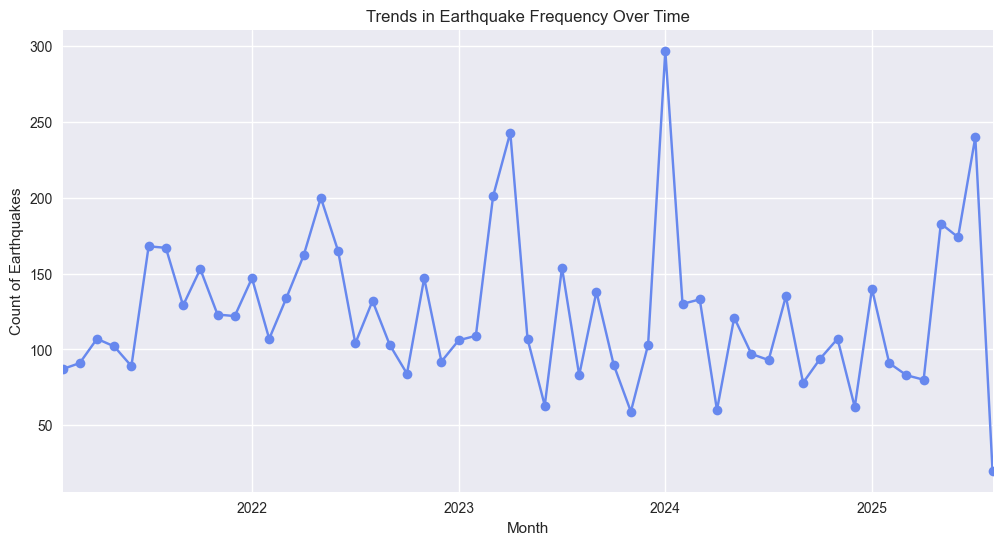

In [71]:
df_count_time = df1.groupby(df1['date'].dt.to_period('M')).size()
df_count_time.index = df_count_time.index.to_timestamp()

# Set style visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("coolwarm")

plt.figure(figsize=(12,6))
df_count_time.plot(kind='line', marker='o')
plt.title("Trends in Earthquake Frequency Over Time")
plt.xlabel("Month")
plt.ylabel("Count of Earthquakes")
plt.grid(True)
plt.show()

 Analisis Tren Jumlah Gempa Dari Waktu ke Waktu (2022–2025)

 1. Fluktuasi Signifikan Setiap Tahun
- Hampir setiap tahun terdapat lonjakan besar jumlah gempa di bulan tertentu.
- Contoh: awal 2023, pertengahan 2024, dan pertengahan 2025.
- Lonjakan ini dapat mengindikasikan periode aktivitas seismik lebih tinggi, kemungkinan akibat pergerakan lempeng atau swarm gempa.

 2. Tidak Ada Tren Naik/Turun yang Konsisten
- Periode 2022–2025 menunjukkan pola naik-turun tajam, tanpa tren meningkat atau menurun yang jelas.
- Aktivitas gempa bersifat episodik, bukan meningkat secara gradual.

 3. Puncak Ekstrem
- Puncak tertinggi terjadi sekitar awal–pertengahan 2023 dan pertengahan 2025, dengan jumlah lebih dari 200 kejadian.
- Puncak semacam ini bisa terkait dengan gempa besar yang memicu serangkaian gempa susulan (aftershocks).

 4. Bulan dengan Aktivitas Rendah
- Beberapa titik rendah di bawah 50 kejadian, misalnya pertengahan 2024 dan akhir 2025.
- Titik rendah sering muncul setelah periode aktivitas tinggi, menandakan masa “tenang” sementara.

---

> 2. Bagaimana distribusi frekuensi kejadian gempa bumi jika dikelompokkan berdasarkan kategori magnitude?

C:\Users\User\AppData\Local\Temp\ipykernel_16972\3521023285.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='mag_category', data=df1, order=labels, palette='viridis')


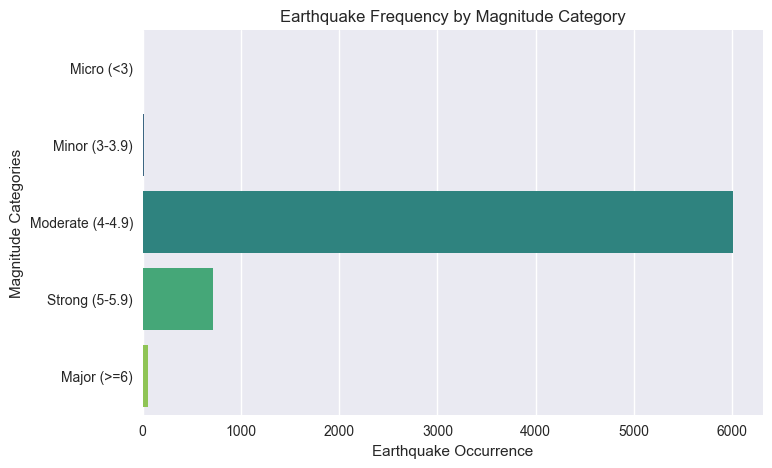

In [72]:
bins = [0, 3, 4, 5, 6, 10]
labels = ['Micro (<3)', 'Minor (3-3.9)', 'Moderate (4-4.9)', 'Strong (5-5.9)', 'Major (>=6)']
df1['mag_category'] = pd.cut(df1['mag'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(8,5))
sns.countplot(y='mag_category', data=df1, order=labels, palette='viridis')
plt.title("Earthquake Frequency by Magnitude Category")
plt.xlabel("Earthquake Occurrence")
plt.ylabel("Magnitude Categories")
plt.show()

 Analisis Frekuensi Gempa per Kategori Magnitudo

 1. Dominasi Gempa Moderat (4–4.9 SR)
- Jumlah kejadian hampir **5.000 gempa**, jauh lebih tinggi dibanding kategori lainnya.
- Menunjukkan sebagian besar aktivitas seismik berada pada tingkat sedang yang cukup terasa,
  namun jarang menimbulkan kerusakan besar jika pusat gempa jauh dari permukiman.

 2. Gempa Kuat (5–5.9 SR) Relatif Jarang
- Hanya sekitar **600-an kejadian**.
- Meski jarang, kategori ini berpotensi merusak infrastruktur, terutama jika kedalaman gempa dangkal.

 3. Gempa Besar (≥6 SR) Sangat Jarang
- Jumlahnya sangat sedikit dibanding kategori lain.
- Dampak sosial-ekonomi bisa sangat besar walau frekuensinya rendah.

 4. Gempa Minor & Mikro Hampir Tidak Terdata
- Kemungkinan karena keterbatasan sensor atau fokus data pada magnitudo ≥3.
- Gempa mikro biasanya terdeteksi di jaringan seismograf lokal dan jarang dilaporkan jika tidak signifikan.

---

 Rekomendasi untuk BNPB
1. **Edukasi Publik Tentang Gempa Moderat**
   - Mengajarkan langkah mitigasi sederhana saat guncangan terasa.
2. **Penguatan Infrastruktur Kritis**
   - Standarisasi bangunan tahan gempa minimal untuk magnitudo 5 SR.
3. **Peningkatan Sistem Peringatan Dini Lokal**
   - Memperbanyak sensor di wilayah rawan untuk memantau gempa kecil–sedang.

---

> 3. Lokasi mana saja yang paling rawan terjadinya gempa bumi ?

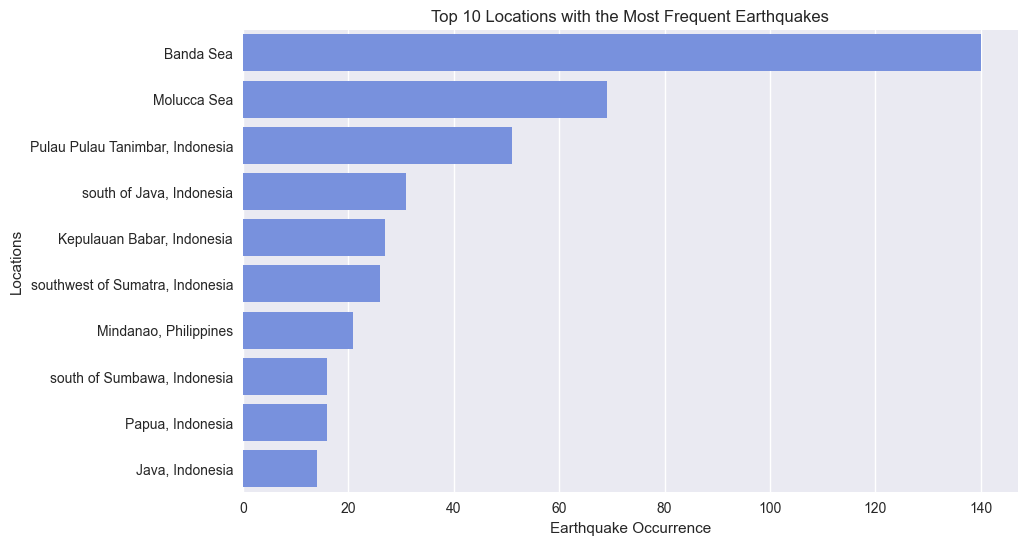

In [73]:
if 'place' in df1.columns:
    top_locations = df1['place'].value_counts().head(10)
    plt.figure(figsize=(10,6))
    sns.barplot(x=top_locations.values, y=top_locations.index)
    plt.title("Top 10 Locations with the Most Frequent Earthquakes")
    plt.xlabel("Earthquake Occurrence")
    plt.ylabel("Locations")
    plt.show()

 Analisis Top 10 Lokasi Paling Sering Terjadi Gempa

 1. Pulau-Pulau Tanimbar, Indonesia
- Paling sering mengalami gempa dengan **lebih dari 50 kejadian**.
- Wilayah ini berada di zona subduksi aktif antara Lempeng Indo-Australia dan Eurasia.

 2. South of Java, Indonesia
- Sekitar **31 kejadian** tercatat.
- Termasuk salah satu jalur megathrust selatan Jawa yang rawan gempa besar.

 3. Kepulauan Babar, Indonesia
- Hampir **27 kejadian**.
- Terletak dekat pertemuan lempeng yang kompleks, memicu aktivitas seismik tinggi.

 4. Southwest of Sumatra, Indonesia
- Sekitar **26 kejadian**.
- Zona ini merupakan bagian dari jalur subduksi Sumatra yang terkenal memicu gempa besar.

 5–10. Wilayah Lain
- **South of Sumbawa** & **Papua**: ±15 kejadian.
- **Java**, **near the north coast of Papua**, **Pulau-Pulau Talaud**, dan **Southern Sumatra**: 11–14 kejadian.
- Meskipun frekuensinya lebih rendah, beberapa wilayah ini berpotensi mengalami gempa besar akibat posisi di jalur pertemuan lempeng.

---

 Rekomendasi untuk BNPB
1. **Prioritaskan Mitigasi di Top 3 Lokasi**
   - Tanimbar, selatan Jawa, dan Kepulauan Babar mendapat prioritas dalam edukasi publik dan logistik bencana.
2. **Peningkatan Pemantauan Seismik**
   - Penambahan sensor gempa di wilayah yang memiliki potensi gempa besar.
3. **Simulasi & Latihan Evakuasi**
   - Dilaksanakan secara rutin di wilayah dengan aktivitas seismik tinggi.

---


> 4. Bagaimana hubungan antara kedalaman gempa dan magnitude-nya?

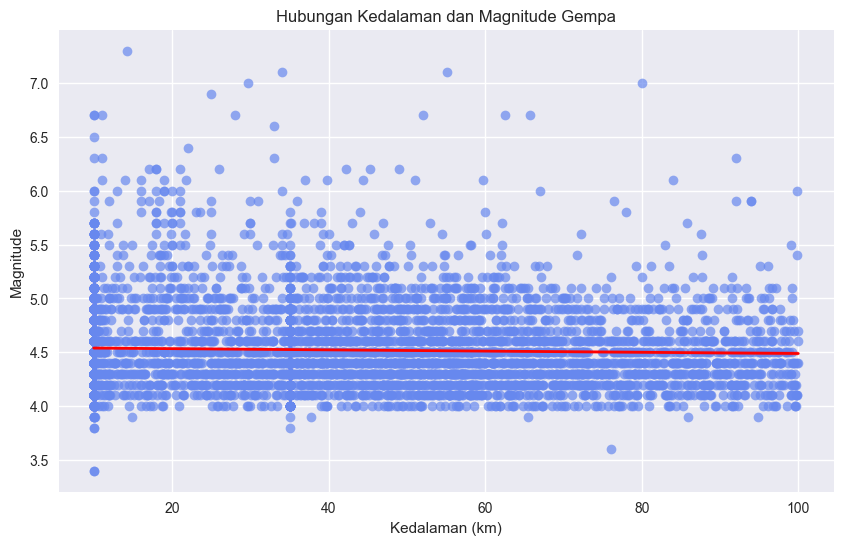

In [15]:
plt.figure(figsize=(10,6))
sns.regplot(
    x='depth', 
    y='mag', 
    data=df1,
    scatter_kws={'alpha':0.7},       
    line_kws={'color':'red', 'linewidth':2}  
)
plt.title("Hubungan Kedalaman dan Magnitude Gempa")
plt.xlabel("Kedalaman (km)")
plt.ylabel("Magnitude")
plt.show()

 Analisis Hubungan Kedalaman dan Magnitude Gempa

 Pola Hubungan
- Garis tren regresi menunjukkan hubungan yang **cenderung datar**.
- Perubahan kedalaman **tidak secara signifikan** memengaruhi besarnya magnitudo gempa.

 Sebaran Data
- Magnitudo gempa umumnya berada di kisaran **4,0–5,5**.
- Beberapa gempa besar (di atas 6,0) terjadi di berbagai kedalaman, baik dangkal maupun menengah.
- Sebaran titik relatif merata pada kedalaman 0–100 km, tanpa pola peningkatan atau penurunan yang jelas.

 Implikasi
- Magnitudo gempa kemungkinan lebih dipengaruhi oleh faktor geologi atau mekanisme patahan daripada kedalaman semata.
- Kedalaman **bukan prediktor tunggal** untuk menentukan besar kecilnya magnitudo.
- Disarankan menggabungkan variabel lain seperti:
  - Lokasi tektonik
  - Jenis sesar
  - Tekanan lempeng

---

> 5. Seberapa signifikan jumlah stasiun dalam menentukan besarnya magnitude yang tercatat?

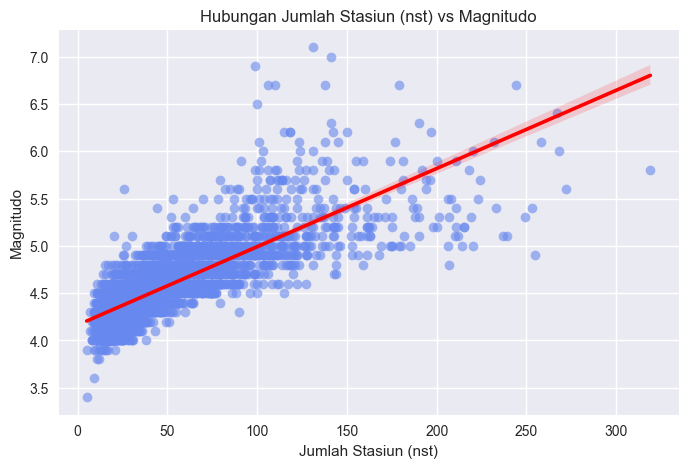

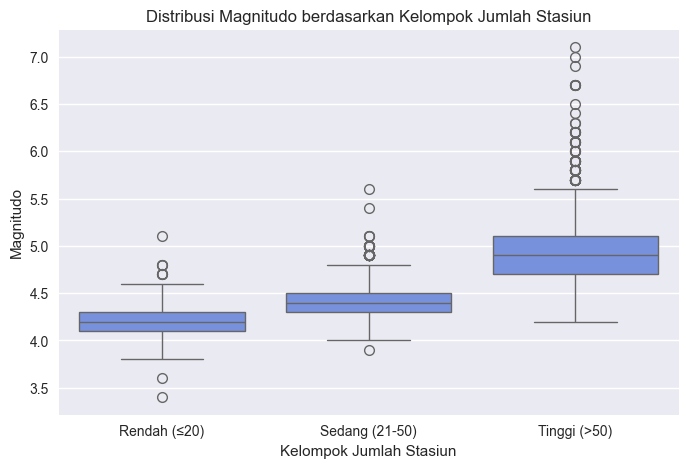

Korelasi Pearson antara nst dan mag: 0.801 (p_value: 0.000)


In [16]:

# --- Scatter Plot ---
plt.figure(figsize=(8, 5))
sns.regplot(x='nst', y='mag', data=df1, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title('Hubungan Jumlah Stasiun (nst) vs Magnitudo')
plt.xlabel('Jumlah Stasiun (nst)')
plt.ylabel('Magnitudo')
plt.grid(True)
plt.show()


# --- Boxplot dengan Kelompok ---
# Membuat kategori jumlah stasiun
bins = [0, 20, 50, df1['nst'].max()]
labels = ['Rendah (≤20)', 'Sedang (21-50)', 'Tinggi (>50)']
df1['nst_group'] = pd.cut(df1['nst'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(8, 5))
sns.boxplot(x='nst_group', y='mag', data=df1)
plt.title('Distribusi Magnitudo berdasarkan Kelompok Jumlah Stasiun')
plt.xlabel('Kelompok Jumlah Stasiun')
plt.ylabel('Magnitudo')
plt.grid(True, axis='y')
plt.show()

# Buang NaN di kedua kolom sekaligus
valid_data = df1[['nst', 'mag']].dropna()

# Hitung korelasi
corr, p_val = pearsonr(valid_data['nst'], valid_data['mag'])
print(f"Korelasi Pearson antara nst dan mag: {corr:.3f} (p_value: {p_val:.3f})")



 Analisis Hubungan Jumlah Stasiun (nst) vs Magnitudo Gempa

 1. Scatter Plot – Hubungan Jumlah Stasiun vs Magnitudo
**Pola Umum**  
- Terdapat hubungan positif: semakin besar magnitudo gempa, semakin banyak stasiun yang mendeteksinya.

**Sebaran Data**  
- Magnitudo kecil (3,5–4,5): jumlah stasiun relatif sedikit (banyak di bawah 50).
- Magnitudo menengah–besar (>5): jumlah stasiun bervariasi, dapat mencapai >300.

**Interpretasi**  
- Gempa yang lebih besar memiliki gelombang seismik yang lebih kuat dan menjangkau area lebih luas, sehingga terdeteksi oleh lebih banyak stasiun.

---

 2. Boxplot – Distribusi Magnitudo Berdasarkan Kelompok Jumlah Stasiun
- **Rendah (≤20 stasiun)**: Median magnitudo ~4,2. Rentang sempit, mayoritas gempa kecil.
- **Sedang (21–50 stasiun)**: Median ~4,4, sebaran lebih lebar.
- **Tinggi (>50 stasiun)**: Median ~5,0, sebaran luas dengan outlier hingga >7 SR.

**Interpretasi**  
- Semakin banyak stasiun yang mencatat, cenderung magnitudo gempa yang tercatat lebih besar.

---

 3. Uji Korelasi Pearson
- **Nilai Korelasi (r)**: 0.802 → hubungan kuat dan positif.  

    Uji Korelasi antara nst(jumlah stasiun yang merekam gempa) dan magnitudo
    H0 : Tidak ada hubungan linear yang signifikan antara variabel nst dan mag
    
    H1 : Ada hubungan linear yang signifikan antara nst dan mag
- **p-value**: 0.000 (<0.05) → hubungan signifikan secara statistik antara nst dan mag.

**Kesimpulan**  
- Ada hubungan linear yang kuat antara jumlah stasiun dan magnitudo.  
- Gempa besar lebih mudah terdeteksi oleh jaringan stasiun yang luas.

---

 Ringkasan Insight
**Fakta Penting**  
- Gempa besar lebih cepat dan mudah terdeteksi oleh jaringan stasiun yang luas.

**Implikasi Praktis**  
1. Peningkatan jumlah stasiun akan meningkatkan deteksi gempa kecil di wilayah terpencil.  
2. Data ini membantu **BNPB/BMKG** memprioritaskan penambahan stasiun di daerah rawan gempa dengan cakupan rendah.  
3. Hubungan kuat ini dapat menjadi model awal prediksi magnitudo berdasarkan jumlah stasiun yang menerima sinyal awal.

---

# Feature Engineering

## a. Cardinality Check

In [17]:
# Ambil kolom kategorikal
cat_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Membuat list untuk simpan hasil
list_col = []

for col in cat_columns:
    n_unique = df[col].nunique()
    unique_vals = df[col].unique()
    list_col.append({
        'feature': col,
        'Jumlah Nilai yang unik': n_unique,
        'unique_values': unique_vals
    })

# Ubah jadi DataFrame
cat = pd.DataFrame(list_col)

# Tampilkan
pd.set_option('display.max_colwidth', None)  # agar nilai tidak terpotong
display(cat)

,feature,Jumlah Nilai yang unik,unique_values
0,time,4281,"[15:16:20, 07:35:24, 02:26:11, 17:26:20, 05:40:44, 01:08:13, 09:09:39, 05:53:35, 23:13:26, 21:57:21, 03:38:13, 19:11:41, 18:55:46, 06:07:37, 13:32:45, 20:29:08, 21:49:21, 08:55:31, 20:29:30, 19:14:06, 08:54:19, 09:27:36, 03:52:49, 04:21:27, 20:58:58, 13:14:33, 07:12:37, 02:38:43, 19:20:08, 22:15:02, 01:19:25, 17:00:11, 09:30:12, 16:38:48, 05:14:18, 23:49:30, 20:47:38, 16:57:27, 05:16:50, 04:28:09, 23:12:07, 01:19:22, 16:21:07, 16:06:02, 13:11:39, 11:54:47, 14:10:22, 07:15:23, 00:56:09, 21:41:08, 17:44:37, 13:59:57, 02:12:15, 12:52:03, 22:21:01, 21:58:15, 17:08:56, 10:20:23, 14:30:24, 01:55:11, 05:23:58, 03:56:48, 05:56:39, 20:30:28, 19:54:16, 15:11:23, 23:56:25, 16:42:56, 14:00:20, 21:11:47, 23:18:04, 02:57:53, 04:22:27, 04:02:44, 04:15:03, 17:55:51, 00:34:02, 10:16:30, 07:55:20, 08:15:59, 07:10:21, 22:59:24, 19:10:31, 01:00:08, 00:59:30, 01:59:37, 19:23:54, 04:59:20, 04:55:29, 04:53:26, 15:12:13, 21:39:27, 13:29:14, 11:59:59, 13:43:14, 15:42:47, 16:35:39, 12:09:32, 00:32:00, 12:25:53, ...]"
1,magType,6,"[mb, mww, ml, mwr, mwb, mwc]"
2,net,1,[us]
3,id,6789,"[us6000qxv8, us6000qwup, us6000qwsi, us6000qvpp, us6000qvk9, us6000qve7, us6000qvae, us6000qv9l, us6000qv8p, us6000qv7n, us6000quzc, us6000qupe, us6000qup2, us6000qulk, us6000qulb, us6000queh, us6000qudq, us6000qubl, us6000qu8a, us6000qu6e, us6000qu3r, us7000qe02, us6000qxc9, us7000qdxj, us7000qduu, us7000qdsk, us7000qdrz, us7000qdku, us7000qdh5, us6000qwlq, us7000qdbl, us7000qd9t, us7000qd6b, us7000qd09, us6000qvyl, us6000qvpi, us7000qcuv, us7000qcst, us7000qcsg, us7000qcqq, us7000qcq7, us7000qcp9, us7000qcl6, us7000qcl2, us7000qcky, us7000qckq, us7000qcik, us7000qcih, us7000qci9, us6000quq6, us6000quqa, us7000qcft, us6000qupb, us7000qca0, us7000qc6y, us7000qc68, us7000qc58, us6000quf8, us7000qc0q, us6000qu7c, us7000qbrj, us7000qbp1, us6000qtws, us7000qbgp, us7000qbem, us7000qdhf, us7000qdg9, us7000qdg2, us7000qb4f, us7000qb37, us7000qaxi, us7000qd0n, us7000qavk, us7000qavj, us7000qavc, us7000qav4, us7000qcul, us7000qamm, us7000qald, us7000qal8, us7000qal5, us7000qakg, us7000qafq, us7000qclv, us7000qac2, us7000qabf, us7000qa74, us7000qc38, us7000qa65, us7000qa4u, us7000qa23, us7000q9yp, us7000qc1u, us7000q9yi, us7000qc1k, us7000q9r7, us7000qbuv, us7000q9ns, us7000q9mq, us7000qbtq, ...]"
4,updated,4589,"[2025-08-03T15:16:20.040Z, 2025-07-31T07:35:24.040Z, 2025-07-31T02:26:11.040Z, 2025-07-30T17:26:20.009Z, 2025-07-28T05:40:44.040Z, 2025-07-27T01:08:13.040Z, 2025-07-26T09:09:39.040Z, 2025-07-27T05:53:35.962Z, 2025-07-25T23:13:26.040Z, 2025-07-26T21:57:21.308Z, 2025-07-25T03:38:13.040Z, 2025-07-24T19:11:41.040Z, 2025-07-24T18:55:46.040Z, 2025-07-27T06:07:37.858Z, 2025-07-25T13:32:45.489Z, 2025-07-23T20:29:08.040Z, 2025-07-23T21:49:21.040Z, 2025-07-24T08:55:31.373Z, 2025-07-22T20:29:30.040Z, 2025-07-22T19:14:06.040Z, 2025-07-22T08:54:19.040Z, 2025-07-20T09:27:36.040Z, 2025-08-02T03:52:49.040Z, 2025-07-20T04:21:27.040Z, 2025-07-19T20:58:58.040Z, 2025-08-01T13:14:33.040Z, 2025-07-19T07:12:37.040Z, 2025-07-19T02:38:43.040Z, 2025-07-18T19:20:08.040Z, 2025-07-31T22:15:02.040Z, 2025-07-18T01:19:25.265Z, 2025-07-31T17:00:11.040Z, 2025-07-18T09:30:12.454Z, 2025-07-16T16:38:48.040Z, 2025-08-02T05:14:18.040Z, 2025-07-28T23:49:30.040Z, 2025-07-28T20:47:38.040Z, 2025-07-15T16:57:27.040Z, 2025-07-17T05:16:50.797Z, 2025-07-15T04:28:09.040Z, 2025-07-28T23:12:07.040Z, 2025-07-28T01:19:22.040Z, 2025-07-27T16:21:07.040Z, 2025-07-27T16:06:02.040Z, 2025-07-14T13:11:39.040Z, 2025-07-14T11:54:47.040Z, 2025-07-15T14:10:22.988Z, 2025-07-14T07:15:23.205Z, 2025-08-01T00:56:09.040Z, 2025-07-24T21:41:08.040Z, 2025-07-26T17:44:37.040Z, 2025-07-27T13:59:57.040Z, 2025-07-25T02:12:15.040Z, 2025-08-03T12:52:03.040Z, 2025-08-02T22:21:01.040Z, 2025-07-27T21:58:15.040Z, 2025-07-12T17:08:56.040Z, 2025-08-04T10:20:23.040Z, 2025-07-12T14:30:24.650Z, 2025-07-27T01:55:11.040Z, 2025-07-26T05:23:58.040Z, 2025-07-27T03:56:48.040Z, 2025-07-23T05:56:39.040Z, 2025-

 Analisis Cardinality Check

**Tujuan**  
Pemeriksaan *cardinality* dilakukan untuk mengetahui jumlah nilai unik pada setiap fitur. Informasi ini membantu dalam:
- Menentukan metode *encoding* yang tepat untuk fitur kategorikal.
- Mengidentifikasi fitur dengan nilai terlalu unik (*identifier-like*) yang berisiko menyebabkan *overfitting*.
- Memutuskan apakah sebuah fitur perlu dihapus atau diubah sebelum masuk ke proses pemodelan.

**Kategori Cardinality**
| **Kategori**        | **Jumlah Unik Nilai** |
| ------------------- | --------------------- |
| **Low Cardinality** | < 10 – 15              |
| **Medium**          | 15 – 50                |
| **High**            | > 50 – 100             |
| **Very High**       | > 1.000                |

**Hasil Analisis**
- **Very High Cardinality**  
  `id`, `time`, `place`
  → Umumnya berisi nilai unik seperti  ID. Cenderung tidak informatif secara langsung untuk model dan berpotensi dihapus.
  
- **Low Cardinality**  
  `magType`, `net`, `type`, `status`, `locationSource`, `magSource`  
  → Memiliki sedikit variasi nilai.



### Handling Cardinality

Karena pada kolom atau fitur `place` masih memuat banyak informasi seperti arah mata angin, jarak pusat gempa dengan titik referensi, nama kota dan nama negara maka dilakukan spliting untuk memisahkan beberapa informasi tersebut dan kemudian dilihat apakah fitur - fitur tersebut berkorelasi dengan target apa tidak. Pertama - tama yang dilakukan adalah mengecek jumlah value yang sering muncul pada kolom 'place'. 

In [18]:
# Menampilkan jumlah values yang sering muncul pada kolom 'place'
df['place'].value_counts()

place
Banda Sea                          140
Molucca Sea                         69
Pulau Pulau Tanimbar, Indonesia     51
south of Java, Indonesia            31
Kepulauan Babar, Indonesia          27
                                  ... 
145 km E of Tobelo, Indonesia        1
58 km NNW of Ende, Indonesia         1
20 km NE of Kupang, Indonesia        1
105 km NNW of Ambon, Indonesia       1
85 km N of Tobelo, Indonesia         1
Name: count, Length: 5369, dtype: int64

Pada tahap ini dilakukan proses ekstraksi dan pembersihan data pada kolom `place` untuk mendapatkan informasi yang lebih terstruktur. Pertama, data difilter agar hanya menyisakan baris yang memiliki kata "Indonesia", sehingga fokus analisis terbatas pada kejadian yang terjadi di wilayah Indonesia. Selanjutnya, dari kolom place diekstrak angka yang menunjukkan jarak (dalam kilometer) dan dikonversi menjadi tipe data numerik agar dapat digunakan dalam analisis kuantitatif.

Kemudian, dilakukan ekstraksi arah kejadian (misalnya N, S, E, WSW) yang terletak di antara satuan jarak dan kata "of". Setelah itu, diambil nama lokasi yang berada setelah kata "of" dan sebelum tanda koma, sehingga diperoleh nama daerah spesifik terjadinya kejadian. Terakhir, dari informasi yang dipisahkan dengan koma pada kolom place, diambil elemen terakhir sebagai nama negara dan dibersihkan dari spasi yang tidak perlu.

Hasil dari proses ini adalah dataset yang memiliki kolom tambahan berupa distance_km, direction, location, dan country yang siap digunakan untuk analisis lebih lanjut.

In [19]:
# Filter hanya yang di Indonesia
df = df[df['place'].str.contains("Indonesia", case=False, na=False)]

# Ekstrak angka di awal (sebelum " km")
df['distance_km'] = df['place'].str.extract(r'(\d+(?:\.\d+)?)').astype(float)

# Ambil arah (jika ada)
df['direction'] = df['place'].str.extract(r'km\s+([A-Z]+)\s+of')

# Ambil lokasi (setelah "of" dan sebelum koma pertama)
df['location'] = df['place'].str.extract(r'of\s+([^,]+)')

# Ambil negara (setelah koma terakhir)
df['country'] = df['place'].str.split(',').str[-1].str.strip()

df 

C:\Users\User\AppData\Local\Temp\ipykernel_16972\4003618543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_km'] = df['place'].str.extract(r'(\d+(?:\.\d+)?)').astype(float)
C:\Users\User\AppData\Local\Temp\ipykernel_16972\4003618543.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction'] = df['place'].str.extract(r'km\s+([A-Z]+)\s+of')
C:\Users\User\AppData\Local\Temp\ipykernel_16972\4003618543.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,magError,magNst,status,locationSource,magSource,date,distance_km,direction,location,country
0,15:16:20,-5.3332,133.5619,35.929,4.5,mb,24.0,66,2.729,0.53,...,0.157,12,reviewed,us,us,2025-08-03,95.0,ENE,Tual,Indonesia
1,07:35:24,-6.6500,130.5304,84.542,4.4,mb,24.0,74,2.204,0.90,...,0.131,17,reviewed,us,us,2025-07-31,270.0,WSW,Tual,Indonesia
2,02:26:11,-3.5954,140.6754,35.000,4.8,mb,19.0,113,1.074,1.22,...,0.116,23,reviewed,us,us,2025-07-31,110.0,S,Abepura,Indonesia
3,17:26:20,6.6995,93.1229,10.000,6.5,mww,100.0,62,4.075,0.78,...,0.061,26,reviewed,us,us,2025-07-30,258.0,WNW,Sabang,Indonesia
4,05:40:44,-3.2344,130.7315,10.000,4.9,mb,59.0,58,1.522,0.85,...,0.077,55,reviewed,us,us,2025-07-28,177.0,W,Fakfak,Indonesia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,22:38:59,-6.1446,103.7619,35.000,4.4,mb,NaN,64,1.945,0.90,...,0.110,24,reviewed,us,us,2021-02-12,183.0,WSW,Bandar Lampung,Indonesia
6785,18:29:33,-8.8869,117.7075,10.000,4.3,mb,NaN,42,3.539,0.82,...,0.116,29,reviewed,us,us,2021-02-06,53.0,SE,Sumbawa Besar,Indonesia
6786,18:29:55,-3.0589,137.6286,51.650,4.3,mb,NaN,220,5.374,0.78,...,0.160,11,reviewed,us,us,2021-02-06,238.0,E,Nabire,Indonesia
6787,18:29:25,-5.4501,130.4064,10.000,4.6,mb,NaN,65,2.667,1.18,...,0.158,12,reviewed,us,us,2021-02-06,260.0,W,Tual,Indonesia


Pada tahap ini dilakukan preprocessing pada variabel kategorikal location agar lebih siap digunakan dalam analisis. Langkah pertama adalah mengelompokkan lokasi yang jarang muncul menjadi kategori "Other". Lokasi dianggap jarang jika jumlah kemunculannya kurang dari 10 (threshold). Proses ini dilakukan dengan menghitung frekuensi setiap lokasi, lalu mengganti lokasi dengan frekuensi di bawah ambang batas menjadi "Other".

In [20]:
# 1. mapping kota ke pulau
location_to_region = {
    # Maluku & Papua
    'Tual': 'Maluku', 'Abepura': 'Papua', 'Fakfak': 'Papua Barat', 'Sorong': 'Papua Barat',
    'Masohi': 'Maluku', 'Ambon': 'Maluku', 'Biak': 'Papua', 'Jayapura': 'Papua',
    
    # Sulawesi
    'Bitung': 'Sulawesi Utara', 'Luwuk': 'Sulawesi Tengah', 'Gorontalo': 'Sulawesi Utara',
    'Palu': 'Sulawesi Tengah', 'Makassar': 'Sulawesi Selatan',
    
    # Sumatra
    'Bengkulu': 'Sumatra', 'Padang': 'Sumatra Barat', 'Medan': 'Sumatra Utara',
    'Banda Aceh': 'Aceh', 'Jambi City': 'Jambi',
    
    # Jawa & Bali
    'Surabaya': 'Jawa Timur', 'Cilacap': 'Jawa Tengah', 'Bandar Lampung': 'Sumatra',
    'Denpasar': 'Bali', 'Ubud': 'Bali', 'Nusa Dua': 'Bali',
    
    # NTT & NTB
    'Labuan Bajo': 'NTT', 'Kupang': 'NTT', 'Waingapu': 'NTT',
    'Mataram': 'NTB', 'Praya': 'NTB', 'Lombok': 'NTB',

    # Default
}

# 2. Map location ke region
df['location_grouped'] = df['location'].map(location_to_region).fillna('Other')
df


C:\Users\User\AppData\Local\Temp\ipykernel_16972\2876966986.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['location_grouped'] = df['location'].map(location_to_region).fillna('Other')


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,magNst,status,locationSource,magSource,date,distance_km,direction,location,country,location_grouped
0,15:16:20,-5.3332,133.5619,35.929,4.5,mb,24.0,66,2.729,0.53,...,12,reviewed,us,us,2025-08-03,95.0,ENE,Tual,Indonesia,Maluku
1,07:35:24,-6.6500,130.5304,84.542,4.4,mb,24.0,74,2.204,0.90,...,17,reviewed,us,us,2025-07-31,270.0,WSW,Tual,Indonesia,Maluku
2,02:26:11,-3.5954,140.6754,35.000,4.8,mb,19.0,113,1.074,1.22,...,23,reviewed,us,us,2025-07-31,110.0,S,Abepura,Indonesia,Papua
3,17:26:20,6.6995,93.1229,10.000,6.5,mww,100.0,62,4.075,0.78,...,26,reviewed,us,us,2025-07-30,258.0,WNW,Sabang,Indonesia,Other
4,05:40:44,-3.2344,130.7315,10.000,4.9,mb,59.0,58,1.522,0.85,...,55,reviewed,us,us,2025-07-28,177.0,W,Fakfak,Indonesia,Papua Barat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,22:38:59,-6.1446,103.7619,35.000,4.4,mb,NaN,64,1.945,0.90,...,24,reviewed,us,us,2021-02-12,183.0,WSW,Bandar Lampung,Indonesia,Sumatra
6785,18:29:33,-8.8869,117.7075,10.000,4.3,mb,NaN,42,3.539,0.82,...,29,reviewed,us,us,2021-02-06,53.0,SE,Sumbawa Besar,Indonesia,Other
6786,18:29:55,-3.0589,137.6286,51.650,4.3,mb,NaN,220,5.374,0.78,...,11,reviewed,us,us,2021-02-06,238.0,E,Nabire,Indonesia,Other
6787,18:29:25,-5.4501,130.4064,10.000,4.6,mb,NaN,65,2.667,1.18,...,12,reviewed,us,us,2021-02-06,260.0,W,Tual,Indonesia,Maluku


In [21]:
df['location_grouped'].unique()

array(['Maluku', 'Papua', 'Other', 'Papua Barat', 'Sumatra',
       'Sulawesi Tengah', 'NTT', 'Sulawesi Utara', 'Jawa Tengah', 'Aceh',
       'NTB', 'Bali', 'Sumatra Barat', 'Jawa Timur', 'Jambi'],
      dtype=object)

Karena `location` sudah dikelompokkan menjadi `location_grouped` nilai unik nya jadi semakin sedikit dibandingkan `location` sebelum dikelompokkan. Maka dari itu `location` disini dapat dihapus dan `location_grouped` dapat didrop.

In [22]:
df.drop('location', axis=1, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_16972\3113296591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('location', axis=1, inplace=True)


In [23]:
df.rename(columns={'location_grouped': 'location'}, inplace=True)

df

C:\Users\User\AppData\Local\Temp\ipykernel_16972\813067341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'location_grouped': 'location'}, inplace=True)


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,magError,magNst,status,locationSource,magSource,date,distance_km,direction,country,location
0,15:16:20,-5.3332,133.5619,35.929,4.5,mb,24.0,66,2.729,0.53,...,0.157,12,reviewed,us,us,2025-08-03,95.0,ENE,Indonesia,Maluku
1,07:35:24,-6.6500,130.5304,84.542,4.4,mb,24.0,74,2.204,0.90,...,0.131,17,reviewed,us,us,2025-07-31,270.0,WSW,Indonesia,Maluku
2,02:26:11,-3.5954,140.6754,35.000,4.8,mb,19.0,113,1.074,1.22,...,0.116,23,reviewed,us,us,2025-07-31,110.0,S,Indonesia,Papua
3,17:26:20,6.6995,93.1229,10.000,6.5,mww,100.0,62,4.075,0.78,...,0.061,26,reviewed,us,us,2025-07-30,258.0,WNW,Indonesia,Other
4,05:40:44,-3.2344,130.7315,10.000,4.9,mb,59.0,58,1.522,0.85,...,0.077,55,reviewed,us,us,2025-07-28,177.0,W,Indonesia,Papua Barat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,22:38:59,-6.1446,103.7619,35.000,4.4,mb,NaN,64,1.945,0.90,...,0.110,24,reviewed,us,us,2021-02-12,183.0,WSW,Indonesia,Sumatra
6785,18:29:33,-8.8869,117.7075,10.000,4.3,mb,NaN,42,3.539,0.82,...,0.116,29,reviewed,us,us,2021-02-06,53.0,SE,Indonesia,Other
6786,18:29:55,-3.0589,137.6286,51.650,4.3,mb,NaN,220,5.374,0.78,...,0.160,11,reviewed,us,us,2021-02-06,238.0,E,Indonesia,Other
6787,18:29:25,-5.4501,130.4064,10.000,4.6,mb,NaN,65,2.667,1.18,...,0.158,12,reviewed,us,us,2021-02-06,260.0,W,Indonesia,Maluku


Selanjutnya adalah mencari korelasi antara ketiga kolom yang telah dilakukan di split sebelumnya untuk mendukung keputusan apakah perlu di drop atau tidak pada sub Feature selection. Untuk `distance_km` dilakukan uji korelasi spearman dan untuk `direction`, `country`, dan `location` dilakukan uji korelasi kruskal. Kruskal–Wallis itu versi non-parametric dari ANOVA, cocok untuk data numerik vs kategorikal, distribusi data tidak normal dan kategori bisa lebih dari 2.

In [24]:
# Uji korelasi pada 'distance_km'
df[['distance_km', 'mag']].corr(method='spearman')

,distance_km,mag
distance_km,1.000000,-0.028028
mag,-0.028028,1.000000


In [25]:
features = ['direction', 'country', 'location']
results = []

for feature in features:
    # Drop NaN
    temp_df = df[[feature, 'mag']].dropna()

    # Ambil semua grup mag berdasarkan kategori (yang punya > 1 sampel)
    groups = [group['mag'].values for _, group in temp_df.groupby(feature) if len(group) > 1]
    
    # Pastikan minimal 2 grup untuk diuji
    if len(groups) >= 2:
        stat, p_val = kruskal(*groups)
        interpretation = "Significant" if p_val < 0.05 else "Not Significant"
    else:
        stat, p_val, interpretation = None, None, "Not enough data"

    results.append([feature, stat, p_val, interpretation])

kruskal_results = pd.DataFrame(results, columns=["Feature", "H-Statistic", "P-Value", "Interpretation"])
kruskal_results


,Feature,H-Statistic,P-Value,Interpretation
0,direction,14.948476,0.455135,Not Significant
1,country,NaN,NaN,Not enough data
2,location,40.052226,0.000070,Significant


`country` bernilai NaN karena jumlah unik valuenya hanya 1 sehingga tidak memiliki pola dan tidak bisa dilakukan korelasi. Dari beberapa uji korelasi yang dilakukan didapatkan bahwa `distance_km`, `direction`, `country` tidak memiliki pola atau tidak signifikan.

In [26]:
# Ambil kolom kategorikal
cat_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Membuat list untuk simpan hasil
list_col = []

for col in cat_columns:
    n_unique = df[col].nunique()
    unique_vals = df[col].unique()
    list_col.append({
        'feature': col,
        'Jumlah Nilai yang unik': n_unique,
        'unique_values': unique_vals
    })

# Ubah jadi DataFrame
cat = pd.DataFrame(list_col)

# Tampilkan
pd.set_option('display.max_colwidth', None)  # agar nilai tidak terpotong
display(cat)

,feature,Jumlah Nilai yang unik,unique_values
0,time,3601,"[15:16:20, 07:35:24, 02:26:11, 17:26:20, 05:40:44, 01:08:13, 09:09:39, 05:53:35, 23:13:26, 21:57:21, 03:38:13, 19:11:41, 18:55:46, 06:07:37, 13:32:45, 20:29:08, 21:49:21, 08:55:31, 20:29:30, 08:54:19, 09:27:36, 03:52:49, 04:21:27, 20:58:58, 13:14:33, 07:12:37, 02:38:43, 19:20:08, 01:19:25, 17:00:11, 09:30:12, 23:49:30, 20:47:38, 16:57:27, 05:16:50, 23:12:07, 01:19:22, 16:21:07, 16:06:02, 13:11:39, 11:54:47, 14:10:22, 07:15:23, 00:56:09, 21:41:08, 17:44:37, 02:12:15, 12:52:03, 22:21:01, 21:58:15, 17:08:56, 14:30:24, 01:55:11, 05:23:58, 05:56:39, 20:30:28, 19:54:16, 15:11:23, 23:56:25, 16:42:56, 14:00:20, 21:11:47, 23:18:04, 02:57:53, 04:22:27, 04:02:44, 04:15:03, 17:55:51, 00:34:02, 10:16:30, 07:55:20, 08:15:59, 07:10:21, 19:10:31, 00:59:30, 01:59:37, 19:23:54, 04:59:20, 04:55:29, 04:53:26, 15:12:13, 21:39:27, 13:29:14, 11:59:59, 13:43:14, 15:42:47, 16:35:39, 12:09:32, 00:32:00, 12:25:53, 22:46:09, 17:29:36, 07:30:47, 07:23:43, 07:39:39, 05:27:52, 16:41:38, 04:52:51, 14:34:03, 23:21:18, ...]"
1,magType,6,"[mb, mww, ml, mwr, mwb, mwc]"
2,net,1,[us]
3,id,5406,"[us6000qxv8, us6000qwup, us6000qwsi, us6000qvpp, us6000qvk9, us6000qve7, us6000qvae, us6000qv9l, us6000qv8p, us6000qv7n, us6000quzc, us6000qupe, us6000qup2, us6000qulk, us6000qulb, us6000queh, us6000qudq, us6000qubl, us6000qu8a, us6000qu3r, us7000qe02, us6000qxc9, us7000qdxj, us7000qduu, us7000qdsk, us7000qdrz, us7000qdku, us7000qdh5, us7000qdbl, us7000qd9t, us7000qd6b, us6000qvpi, us7000qcuv, us7000qcst, us7000qcsg, us7000qcq7, us7000qcp9, us7000qcl6, us7000qcl2, us7000qcky, us7000qckq, us7000qcik, us7000qcih, us7000qci9, us6000quq6, us6000quqa, us6000qupb, us7000qca0, us7000qc6y, us7000qc68, us7000qc58, us7000qc0q, us6000qu7c, us7000qbrj, us6000qtws, us7000qbgp, us7000qbem, us7000qdhf, us7000qdg9, us7000qdg2, us7000qb4f, us7000qb37, us7000qaxi, us7000qd0n, us7000qavk, us7000qavj, us7000qavc, us7000qav4, us7000qcul, us7000qamm, us7000qald, us7000qal8, us7000qal5, us7000qafq, us7000qac2, us7000qabf, us7000qa74, us7000qc38, us7000qa65, us7000qa4u, us7000qa23, us7000q9yp, us7000qc1u, us7000q9yi, us7000qc1k, us7000q9r7, us7000qbuv, us7000q9ns, us7000q9mq, us7000qbtq, us7000q9ep, us7000qblz, us7000q9d1, us7000q9cw, us7000q923, us7000qbcx, us7000q8zh, us7000qb12, us7000q8mk, us7000qaww, ...]"
4,updated,3827,"[2025-08-03T15:16:20.040Z, 2025-07-31T07:35:24.040Z, 2025-07-31T02:26:11.040Z, 2025-07-30T17:26:20.009Z, 2025-07-28T05:40:44.040Z, 2025-07-27T01:08:13.040Z, 2025-07-26T09:09:39.040Z, 2025-07-27T05:53:35.962Z, 2025-07-25T23:13:26.040Z, 2025-07-26T21:57:21.308Z, 2025-07-25T03:38:13.040Z, 2025-07-24T19:11:41.040Z, 2025-07-24T18:55:46.040Z, 2025-07-27T06:07:37.858Z, 2025-07-25T13:32:45.489Z, 2025-07-23T20:29:08.040Z, 2025-07-23T21:49:21.040Z, 2025-07-24T08:55:31.373Z, 2025-07-22T20:29:30.040Z, 2025-07-22T08:54:19.040Z, 2025-07-20T09:27:36.040Z, 2025-08-02T03:52:49.040Z, 2025-07-20T04:21:27.040Z, 2025-07-19T20:58:58.040Z, 2025-08-01T13:14:33.040Z, 2025-07-19T07:12:37.040Z, 2025-07-19T02:38:43.040Z, 2025-07-18T19:20:08.040Z, 2025-07-18T01:19:25.265Z, 2025-07-31T17:00:11.040Z, 2025-07-18T09:30:12.454Z, 2025-07-28T23:49:30.040Z, 2025-07-28T20:47:38.040Z, 2025-07-15T16:57:27.040Z, 2025-07-17T05:16:50.797Z, 2025-07-28T23:12:07.040Z, 2025-07-28T01:19:22.040Z, 2025-07-27T16:21:07.040Z, 2025-07-27T16:06:02.040Z, 2025-07-14T13:11:39.040Z, 2025-07-14T11:54:47.040Z, 2025-07-15T14:10:22.988Z, 2025-07-14T07:15:23.205Z, 2025-08-01T00:56:09.040Z, 2025-07-24T21:41:08.040Z, 2025-07-26T17:44:37.040Z, 2025-07-25T02:12:15.040Z, 2025-08-03T12:52:03.040Z, 2025-08-02T22:21:01.040Z, 2025-07-27T21:58:15.040Z, 2025-07-12T17:08:56.040Z, 2025-07-12T14:30:24.650Z, 2025-07-27T01:55:11.040Z, 2025-07-26T05:23:58.040Z, 2025-07-23T05:56:39.040Z, 2025-08-02T20:30:28.780Z, 2025-07-20T19:54:16.040Z, 2025-08-01T15:11:23.040Z, 2025-07-31T23:56:25.040Z, 2025-07-20T16:42:56.040Z, 2025-07-31T14:00:20.040Z, 2025-08-01T21:11:47.040Z, 2025-07-25T23:18:04.040Z, 2025-

**Implikasi dan Rencana Tindak Lanjut**
1. Fitur **Very High Cardinality** seperti `id` akan dihapus karena berperan sebagai pengenal unik.  
2. `time` dan `update` akan didrop karena tidak memiliki pola dan bila tidak di drop akan membuat model lelah berfikirkarena nilai uniknya yang sangat banyak.
3. Fitur yang memiliki informasi hanya 1 nilai unik seperti `net`, `type`, `status`, `locationSource`, `magSource` dan `country` akan di drop karena pola tidak terlihat.
4. `direction` didrop karena tidak memiliki pola yanh signifikan terhadap target.
5. Karena sudah dilakukan handling cardinality maka `place` dihapus dan akan digantikan dengan kolom `location`.
6. Fitur `magType` dan `location` merupakan type kategori nominal sehingga akan dilakukan One Hot Encorder.

## b. Split X dan Y

 Pemisahan Input dan Output Sebelum Pelatihan Model

Sebelum melatih model, langkah penting yang dilakukan adalah **memisahkan data menjadi fitur (*input*) dan target (*output*)**.

- **X (Fitur/Input)**  
  Merupakan data yang berisi informasi yang akan digunakan model untuk mempelajari pola.  
  
- **y (Target/Output)**  
  Merupakan data yang berisi nilai atau label yang ingin diprediksi oleh model.  
  Dalam hal ini, yang ditetapkan sebagai target adalah `mag`.

 Mengapa Perlu Dipisahkan?
Saat pelatihan, model berusaha **mencari pola** pada data *input* untuk memprediksi nilai *output*.  
Jika data tidak dipisahkan:
- Model **tidak tahu** mana yang harus diprediksi.
- Risiko **data leakage** (*kebocoran data*) meningkat, di mana model bisa “mengintip” jawaban saat belajar, sehingga kinerjanya tampak bagus saat pelatihan tapi buruk saat prediksi data baru.
---


In [27]:
y = df['mag']
X = df.drop('mag', axis = 1)

X

,time,latitude,longitude,depth,magType,nst,gap,dmin,rms,net,...,magError,magNst,status,locationSource,magSource,date,distance_km,direction,country,location
0,15:16:20,-5.3332,133.5619,35.929,mb,24.0,66,2.729,0.53,us,...,0.157,12,reviewed,us,us,2025-08-03,95.0,ENE,Indonesia,Maluku
1,07:35:24,-6.6500,130.5304,84.542,mb,24.0,74,2.204,0.90,us,...,0.131,17,reviewed,us,us,2025-07-31,270.0,WSW,Indonesia,Maluku
2,02:26:11,-3.5954,140.6754,35.000,mb,19.0,113,1.074,1.22,us,...,0.116,23,reviewed,us,us,2025-07-31,110.0,S,Indonesia,Papua
3,17:26:20,6.6995,93.1229,10.000,mww,100.0,62,4.075,0.78,us,...,0.061,26,reviewed,us,us,2025-07-30,258.0,WNW,Indonesia,Other
4,05:40:44,-3.2344,130.7315,10.000,mb,59.0,58,1.522,0.85,us,...,0.077,55,reviewed,us,us,2025-07-28,177.0,W,Indonesia,Papua Barat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,22:38:59,-6.1446,103.7619,35.000,mb,NaN,64,1.945,0.90,us,...,0.110,24,reviewed,us,us,2021-02-12,183.0,WSW,Indonesia,Sumatra
6785,18:29:33,-8.8869,117.7075,10.000,mb,NaN,42,3.539,0.82,us,...,0.116,29,reviewed,us,us,2021-02-06,53.0,SE,Indonesia,Other
6786,18:29:55,-3.0589,137.6286,51.650,mb,NaN,220,5.374,0.78,us,...,0.160,11,reviewed,us,us,2021-02-06,238.0,E,Indonesia,Other
6787,18:29:25,-5.4501,130.4064,10.000,mb,NaN,65,2.667,1.18,us,...,0.158,12,reviewed,us,us,2021-02-06,260.0,W,Indonesia,Maluku


## c.Split X menjadi X train dan X test

 Pembagian Data Menjadi Train dan Test Set

Setelah data dipisahkan menjadi **X (fitur/input)** dan **y (target/output)**, langkah berikutnya adalah **membagi data menjadi data latih (*train set*) dan data uji (*test set*)**.

 1. Train Set
- Digunakan untuk **melatih model**.
- Model mempelajari pola dari data ini.
- Dibagi menjadi **80%** dari total data.

 2. Test Set
- Digunakan untuk **mengukur performa model** pada data yang belum pernah dilihat.
- Membantu mengevaluasi apakah model bisa melakukan generalisasi.
- Dibagi menjadi **20%** dari total data.

 Tujuan Pembagian
- **Menghindari overfitting**, yaitu kondisi ketika model terlalu menghafal data latih sehingga performanya buruk pada data baru.
- **Mengetahui performa sesungguhnya** model di dunia nyata.
---

In [28]:
# Split train dan test
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4324, 26)
(1082, 26)
(4324,)
(1082,)


In [29]:
# Mengecek nama kolom di train dan test

print(X_train.columns)
print(X_test.columns)

Index(['time', 'latitude', 'longitude', 'depth', 'magType', 'nst', 'gap',
       'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'date', 'distance_km', 'direction',
       'country', 'location'],
      dtype='object')
Index(['time', 'latitude', 'longitude', 'depth', 'magType', 'nst', 'gap',
       'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'date', 'distance_km', 'direction',
       'country', 'location'],
      dtype='object')


## d. Handling Missing Value

In [30]:
X_train.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
magType               0
nst                1422
gap                   0
dmin                  0
rms                   0
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError       0
depthError            0
magError              0
magNst                0
status                0
locationSource        0
magSource             0
date                  0
distance_km         276
direction           276
country               0
location              0
dtype: int64

terdapat nilai yang hilang pada fitur `nst` (Jumlah stasiun seismik yang digunakan untuk menentukan lokasi gempa) sebanyak 1857 dari 4385. Selanjutnya dilakukan pengecekan pada fitur `nst` yang memiliki nilai NaN untuk melihat apakah fitur tersebut berkorelasi atau tidak dengan fitur lainnya.

In [31]:
X_train[X_train['nst'].isna()]

,time,latitude,longitude,depth,magType,nst,gap,dmin,rms,net,...,magError,magNst,status,locationSource,magSource,date,distance_km,direction,country,location
6214,20:16:12,1.6822,128.4637,66.62,mb,NaN,100,1.421,0.59,us,...,0.142,15,reviewed,us,us,2021-07-10,50.0,E,Indonesia,Other
5169,21:01:32,-5.2168,131.2412,51.44,mb,NaN,107,2.493,0.76,us,...,0.169,10,reviewed,us,us,2022-02-24,173.0,WNW,Indonesia,Maluku
5884,22:50:43,2.8069,126.6340,64.68,mb,NaN,148,2.150,0.80,us,...,0.180,10,reviewed,us,us,2021-09-17,193.0,NW,Indonesia,Other
6048,21:33:20,0.3776,126.4711,10.00,mb,NaN,67,0.977,0.81,us,...,0.215,8,reviewed,us,us,2021-08-24,111.0,WSW,Indonesia,Other
6680,23:19:51,2.2903,126.7100,52.01,mb,NaN,119,1.645,0.49,us,...,0.150,13,reviewed,us,us,2021-03-06,157.0,WNW,Indonesia,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6696,23:18:04,-4.4769,101.0465,10.00,mb,NaN,201,1.907,0.53,us,...,0.177,9,reviewed,us,us,2021-03-06,154.0,WSW,Indonesia,Sumatra
4681,14:55:45,-4.3330,130.2802,50.61,mb,NaN,88,2.415,0.59,us,...,0.143,15,reviewed,us,us,2022-05-27,186.0,SE,Indonesia,Other
6504,21:04:42,-5.5384,102.3885,35.00,mb,NaN,201,1.299,0.39,us,...,0.213,6,reviewed,us,us,2021-04-23,192.0,SSW,Indonesia,Other
6548,21:50:31,-0.6277,123.2701,18.54,mb,NaN,56,0.646,0.43,us,...,0.187,8,reviewed,us,us,2021-04-22,64.0,ENE,Indonesia,Sulawesi Tengah


In [32]:
# Buat kolom indikator missing
X_train['nst_missing'] = X_train['nst'].isna()

# Buat tabel kontingensi antara place dan status missing nst
contingency_table = pd.crosstab(X_train['place'], X_train['nst_missing'])

# Uji Chi-square
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("p-value:", p_val)

# Interpretasi
if p_val < 0.05:
    print("Missing value pada kolom 'nst' tergolong MNAR (Missing Not At Random) karena bergantung pada 'place'")
else:
    print("Missing value pada kolom 'nst' cenderung MCAR atau MAR")


Chi-square: 3797.0422952735166
p-value: 0.008599896750165082
Missing value pada kolom 'nst' tergolong MNAR (Missing Not At Random) karena bergantung pada 'place'


Berdasarkan hasil uji Chi-square, diperoleh nilai p-value sebesar 0.0086 (lebih kecil dari 0.05).
Hal ini menunjukkan bahwa terdapat hubungan yang signifikan antara kolom nst (status missing value) dengan kolom place (lokasi).

Dengan kata lain, missing value pada nst tidak muncul secara acak (tidak MCAR), tetapi cenderung bergantung pada lokasi tertentu.
Pola ini termasuk kategori MNAR (Missing Not At Random), yang berarti kemungkinan besar ada faktor yang berkaitan dengan lokasi yang menyebabkan data nst tidak tercatat atau hilang.

Karena nst merupakan jumlah stasiun seismik yang digunakan untuk menentukan lokasi gempa, maka pengisian data nst sebaiknya mempertimbangkan variabel place atau berdasarkan latitude dan longitude. karena bila menghapus data secara sembarangan bisa menimbulkan bias, karena ketidakhadiran data ini dipengaruhi oleh lokasi.

In [33]:
# --- Step 1: clustering di X_train ---
coords_train = np.radians(X_train[['latitude', 'longitude']].to_numpy())

# Jumlah cluster ditentukan manual (misalnya 10), bisa di-tune
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
X_train['cluster'] = kmeans.fit_predict(coords_train)

# Hitung rata-rata nst per cluster
cluster_means = X_train.groupby('cluster')['nst'].mean()
global_mean = X_train['nst'].mean()

# Fungsi imputasi
def impute_nst(row):
    if pd.isna(row['nst']):
        return cluster_means.get(row['cluster'], global_mean)
    return row['nst']

# Imputasi di X_train
X_train['nst'] = X_train.apply(impute_nst, axis=1)

# --- Step 2: terapkan ke X_test ---
coords_test = np.radians(X_test[['latitude', 'longitude']].to_numpy())
X_test['cluster'] = kmeans.predict(coords_test)

X_test['nst'] = X_test.apply(impute_nst, axis=1)


Pada tahap pra-pemrosesan data, variabel nst memiliki sejumlah nilai yang hilang. Untuk mengisi nilai yang hilang tersebut, digunakan pendekatan clustering-based imputation dengan algoritma KMeans. Prosesnya dimulai dengan melakukan pengelompokan data berdasarkan koordinat geografis (latitude dan longitude) untuk membentuk cluster lokasi yang memiliki karakteristik serupa. Selanjutnya, dihitung rata-rata nilai nst pada setiap cluster. Jika suatu entri memiliki nilai nst yang hilang, nilai tersebut akan diisi dengan rata-rata nst dari cluster tempat entri tersebut berada. Jika rata-rata pada cluster tidak tersedia, digunakan rata-rata global seluruh data. Pendekatan ini diharapkan mampu memberikan estimasi yang lebih representatif dibandingkan pengisian nilai secara acak atau menggunakan rata-rata keseluruhan, karena mempertimbangkan kedekatan geografis data.

In [34]:
X_train[X_train['location'].isna()]

,time,latitude,longitude,depth,magType,nst,gap,dmin,rms,net,...,status,locationSource,magSource,date,distance_km,direction,country,location,nst_missing,cluster


In [35]:
X_train.isnull().sum()

time                 0
latitude             0
longitude            0
depth                0
magType              0
nst                  0
gap                  0
dmin                 0
rms                  0
net                  0
id                   0
updated              0
place                0
type                 0
horizontalError      0
depthError           0
magError             0
magNst               0
status               0
locationSource       0
magSource            0
date                 0
distance_km        276
direction          276
country              0
location             0
nst_missing          0
cluster              0
dtype: int64

Nilai NaN pada `nst` sudah bernilai 0 yang berarti bahwa missing value telah terisi.

## e. Handling Outlier

In [36]:
outlier_report = []

col = ['depth', 'nst', 'gap', 'dmin', 'rms', 'horizontalError', 'depthError', 'magError', 'magNst']

for x in col:
    skew = round(X_train[x].skew(), 1)
    distribution = 'skewed' if skew < -0.5 or skew > 0.5 else 'normal'

    if distribution == 'skewed':
        IQR = X_train[x].quantile(0.75) - X_train[x].quantile(0.25)
        lower_boundary = X_train[x].quantile(0.25) - (IQR *1.5)
        upper_boundary = X_train[x].quantile(0.75) + (IQR * 1.5)
    else:
        lower_boundary = X_train[x].mean() - 3 * X_train[x].std()
        upper_boundary = X_train[x].mean() + 3 * X_train[x].std()
    
    n_outlier = ((X_train[x] > upper_boundary) | (X_train[x] < lower_boundary)).sum()
    percent_outlier = (n_outlier / len(X_train)) * 100

    outlier_report.append({
        'Kolom': x,
        'Distribusi': distribution,
        'Skew': skew,
        'Lower Boundary': round(lower_boundary, 2),
        'Upper Boundary': round(upper_boundary, 2),
        'Jumlah Outlier': n_outlier,
        'Persentase Outlier (%)': round(percent_outlier, 2)
    })

outlier = pd.DataFrame(outlier_report)
outlier


,Kolom,Distribusi,Skew,Lower Boundary,Upper Boundary,Jumlah Outlier,Persentase Outlier (%)
0,depth,skewed,0.7,-53.09,115.16,0,0.00
1,nst,skewed,2.8,-15.16,91.94,272,6.29
2,gap,skewed,0.6,-20.00,204.00,44,1.02
3,dmin,skewed,3.7,-0.63,4.47,217,5.02
4,rms,normal,0.4,0.02,1.40,3,0.07
5,horizontalError,skewed,0.6,2.04,12.69,89,2.06
6,depthError,skewed,0.7,-5.75,14.65,5,0.12
7,magError,skewed,1.0,-0.02,0.27,54,1.25
8,magNst,skewed,2.6,-20.50,63.50,377,8.72


In [37]:
X_train.describe().T[['min', 'max']]

,min,max
latitude,-11.8103,7.681
longitude,93.1229,140.9669
depth,10.0,99.774
nst,5.0,319.0
gap,13.0,281.0
dmin,0.006,23.972
rms,0.07,1.53
horizontalError,2.19,16.0
depthError,0.528,20.505
magError,0.027,0.531


#### Keputusan: Tidak Dilakukan Outlier Handling

 Alasan Utama

 1. Sifat Geologis Gempa
  - Gempa bumi adalah fenomena alam yang intrinsiknya variatif.
  - Nilai ekstrem (outlier) seperti `nst = 319` atau `gap = 281` **bukan kesalahan**, melainkan mencerminkan kondisi nyata:
  - Gempa besar terdeteksi oleh banyak stasiun.
  - Gempa di daerah terpencil memiliki cakupan sudut terbatas.

 2. Outlier Memiliki Makna Prediktif
  - Outlier sering berkaitan dengan **gempa besar** — yang justru menjadi fokus prediksi.
  - Menghapus atau mengubah outlier dapat menghilangkan **pola penting** dalam data.

 3. Model yang sebaiknya digunakan adalah Random Forest
  - Random Forest **robust terhadap outlier** karena:
     - Menggunakan median atau split berbasis kuantil.
     - Tidak sensitif terhadap nilai ekstrem selama tidak mendominasi.
     - Membuang outlier justru dapat **mengurangi kemampuan model** untuk memprediksi gempa besar.

 4. Tujuan Prediksi Magnitudo
- Karena tujuannya adalah memprediksi semua jenis gempa, termasuk yang besar, **outlier harus dipertahankan**.
- Handling outlier dapat membuat model **underestimate** magnitudo ekstrem.
---

## f. Feature Selection

Fitur yang perlu dihapus adalah :

- net, status, locationSource, magSource, type karena tidak memiliki pola dan jumlahnya 1.
- id > nilai uniknya banyak berisi id permasing - masing lokasi gempa dan fitur tersebut juga tidak memiliki pola.
- Kolom date dan time dihapus karena gempa bumi tidak memiliki ketergantungan pada waktu kalender atau jam manusia. Tidak ada bukti ilmiah bahwa gempa lebih sering terjadi di hari tertentu atau jam tertentu. Fitur waktu justru berisiko menambah noise atau menyebabkan overfitting terhadap bias deteksi. Fokus model diberikan pada parameter geofisika yang lebih relevan. 
- Place di drop karena informasi mengenai lokasi pusat gempa sudah lebih disederhanakan pada kolom location.

In [38]:
col = ['time', 'date', 'net', 'status', 'locationSource', 'type', 'magSource', 'updated', 'id', 'nst_missing', 'cluster', 'distance_km', 'direction','country', 'place']

X_train.drop(columns=col, inplace=True)

In [39]:
X_train

,latitude,longitude,depth,magType,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst,location
1246,-7.2906,129.4469,99.666,mb,34.000000,120,2.787,0.43,9.93,7.756,0.113,22,Other
6214,1.6822,128.4637,66.620,mb,45.743338,100,1.421,0.59,7.60,7.100,0.142,15,Other
1000,0.8143,126.1832,55.127,mb,30.000000,65,1.184,0.80,7.94,5.815,0.113,22,Other
2862,-8.0150,107.8583,66.896,mb,32.000000,78,0.586,0.90,6.42,5.173,0.110,24,Other
109,-3.9780,101.4954,34.424,mb,27.000000,138,1.505,0.83,4.60,6.587,0.129,17,Sumatra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4681,-4.3330,130.2802,50.610,mb,34.690037,88,2.415,0.59,10.80,11.800,0.143,15,Other
6504,-5.5384,102.3885,35.000,mb,53.493392,201,1.299,0.39,4.70,2.000,0.213,6,Other
6548,-0.6277,123.2701,18.540,mb,46.941520,56,0.646,0.43,6.10,5.400,0.187,8,Sulawesi Tengah
6773,5.1679,94.2446,39.260,mb,51.775641,73,2.692,0.58,8.90,6.900,0.087,49,Aceh


## g. Split X_train menjadi numerik dan kategori

Setelah melakukan pemisahan fitur dan target (X dan y), langkah selanjutnya adalah memisahkan fitur numerik dan kategorik. Hal ini penting karena masing-masing jenis fitur memerlukan teknik praproses yang berbeda, seperti standardisasi untuk data numerik dan encoding untuk data kategorik. Dengan pemisahan ini, proses transformasi menjadi lebih terstruktur dan akurat sesuai tipe datanya.

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4324 entries, 1246 to 1039
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         4324 non-null   float64
 1   longitude        4324 non-null   float64
 2   depth            4324 non-null   float64
 3   magType          4324 non-null   object 
 4   nst              4324 non-null   float64
 5   gap              4324 non-null   int64  
 6   dmin             4324 non-null   float64
 7   rms              4324 non-null   float64
 8   horizontalError  4324 non-null   float64
 9   depthError       4324 non-null   float64
 10  magError         4324 non-null   float64
 11  magNst           4324 non-null   int64  
 12  location         4324 non-null   object 
dtypes: float64(9), int64(2), object(2)
memory usage: 472.9+ KB


In [41]:
num_col = ['latitude', 'longitude','depth', 'nst', 'gap', 'dmin', 'rms', 'horizontalError', 'depthError', 'magError', 'magNst']
cat_col = ['magType', 'location']

# Cetak daftar kolom numerik yang belum diproses dan kolom kategorikal
print(f'numerical: {num_col}')
print(f'categorical: {cat_col}')


numerical: ['latitude', 'longitude', 'depth', 'nst', 'gap', 'dmin', 'rms', 'horizontalError', 'depthError', 'magError', 'magNst']
categorical: ['magType', 'location']


In [42]:
# numerical features
X_train_num = X_train[num_col]
X_test_num = X_test[num_col]

# categorical features
X_train_cat = X_train[cat_col]
X_test_cat = X_test[cat_col]

In [43]:
# cek fitur numerik
X_train_num

,latitude,longitude,depth,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
1246,-7.2906,129.4469,99.666,34.000000,120,2.787,0.43,9.93,7.756,0.113,22
6214,1.6822,128.4637,66.620,45.743338,100,1.421,0.59,7.60,7.100,0.142,15
1000,0.8143,126.1832,55.127,30.000000,65,1.184,0.80,7.94,5.815,0.113,22
2862,-8.0150,107.8583,66.896,32.000000,78,0.586,0.90,6.42,5.173,0.110,24
109,-3.9780,101.4954,34.424,27.000000,138,1.505,0.83,4.60,6.587,0.129,17
...,...,...,...,...,...,...,...,...,...,...,...
4681,-4.3330,130.2802,50.610,34.690037,88,2.415,0.59,10.80,11.800,0.143,15
6504,-5.5384,102.3885,35.000,53.493392,201,1.299,0.39,4.70,2.000,0.213,6
6548,-0.6277,123.2701,18.540,46.941520,56,0.646,0.43,6.10,5.400,0.187,8
6773,5.1679,94.2446,39.260,51.775641,73,2.692,0.58,8.90,6.900,0.087,49


In [44]:
# Cek fitur kategori
X_train_cat

,magType,location
1246,mb,Other
6214,mb,Other
1000,mb,Other
2862,mb,Other
109,mb,Sumatra
...,...,...
4681,mb,Other
6504,mb,Other
6548,mb,Sulawesi Tengah
6773,mb,Aceh


## h. Pipeline (ColumnTransformers)

Untuk membangun model klasifikasi dengan pendekatan yang terstruktur, digunakan pipeline scikit-learn yang memisahkan antara preprocessing data numerik dan kategorikal. Pipeline ini terdiri dari :

1. Numerical Pipeline (num_pipeline)

Pada fitur numerik (num_col), dilakukan proses standardisasi menggunakan RobustScaler().RobustScaler tidak menghapus outlier, melainkan menyesuaikan posisi relatifnya agar lebih stabil setelah proses scaling. Artinya, outlier tetap ada dan masih dapat memengaruhi model jika tidak ditangani secara eksplisit [Sumber](https://stackoverflow.com/questions/67455085/robustscaler-from-scikit-learn-not-behaving-properly?utm_source=chatgpt.com#:~:text=RobustScaler%20does%20not%20remove%20outliers.%20When%20fitted%2C%20it%20computes%20a%20scale%20and%20mean%20that%27s%20robust%20to%20outliers.%20Outliers%20however%20would%20later%20be%20transformed%20like%20all%20other%20points%20using%20those%20parameters.).

2. Categorical pipeline (cat_pipeline)

Pada fitur kategori (cat_col), dilakukan proses encoding menggunakan One Hot Encorder. Hal ini dikarenakan fitur yang ada termasuk ke nominal kategori.

3. ColumnTransformer (preprocessing_pipeline)

ColumnTransformer digunakan untuk menerapkan num_pipeline hanya pada kolom numerik, dan cat_pipeline hanya pada kolom kategorikal. Kemudian kedua proses tersebut digabungkan.

In [45]:
# Pipeline numerik
num_pipeline = make_pipeline(
    RobustScaler()
)

cat_pipeline = make_pipeline(
     OneHotEncoder(handle_unknown='ignore')
)

# ColumnTransformer gabungan
preprocessing_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, num_col),
    ('pipe_cat', cat_pipeline, cat_col)
])

preprocessing_pipeline.fit(X_train)

ColumnTransformer(transformers=[('pipe_num',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['latitude', 'longitude', 'depth', 'nst',
                                  'gap', 'dmin', 'rms', 'horizontalError',
                                  'depthError', 'magError', 'magNst']),
                                ('pipe_cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['magType', 'location'])])

# 1. Algoritma KNN (K-Nearest Neighbor)

## a. Model Definition

 Penjelasan KNN Regression (berdasarkan Scikit-learn, 2024)

1. **Metode Dasar**  
   - KNN Regression memprediksi nilai target dengan cara **melihat k tetangga terdekat** dari data uji berdasarkan jarak tertentu (misalnya Euclidean distance).  
   - *(Scikit-learn: "Regression based on k-nearest neighbors.")*  

2. **Proses Prediksi**  
   - Nilai target diperkirakan melalui **interpolasi lokal** dari nilai target milik tetangga terdekat pada data latih.  
   - *(Scikit-learn: "The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.")*  

3. **Parameter Utama**  
   - **`n_neighbors`**: jumlah tetangga yang dipertimbangkan.  
   - **`weights`**: bobot kontribusi tiap tetangga (uniform atau berdasarkan jarak).  
   - **`metric`**: metode perhitungan jarak (default = Euclidean).  

4. **Kelebihan pada Prediksi Gempa**  
   - Tidak memerlukan asumsi distribusi data.  
   - Dapat menangkap pola non-linear pada hubungan antara fitur (misalnya lokasi, kedalaman) dan magnitudo gempa.  

5. **Keterbatasan**  
   - Sensitif terhadap *noise* dan pemilihan parameter `k`.  
   - Waktu prediksi meningkat jika dataset sangat besar karena perhitungan jarak dilakukan saat inferensi.

**Referensi:**  
Scikit-learn: Machine Learning in Python. *Journal of Machine Learning Research*, 12, 2825–2830.  
[https://scikit-learn.org/stable/modules/neighbors.html](https://scikit-learn.org/stable/modules/neighbors.html)


## b. Model Training KNN (K-Nearest Neighbor)

In [46]:
# Gabung dengan model
knn = make_pipeline(
    preprocessing_pipeline,
    KNeighborsRegressor(n_neighbors=5)
)

# Training
knn.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['latitude', 'longitude',
                                                   'depth', 'nst', 'gap',
                                                   'dmin', 'rms',
                                                   'horizontalError',
                                                   'depthError', 'magError',
                                                   'magNst']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['magType', 'location'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

Proses pelatihan model dilakukan menggunakan algoritma **K-Nearest Neighbors Regressor (KNN)** yang diimplementasikan dengan library **Scikit-learn** (Pedregosa et al., 2011) dengan cara: 
   - Pipeline yang memuat preprocessing dan model KNN dijalankan pada data latih (`X_train`, `y_train`) menggunakan metode `.fit()`.
   - Model mempelajari struktur data latih, sehingga dapat menentukan tetangga terdekat saat melakukan prediksi.


## c. Model Evaluasi : KNN (K-Nearest Neighbor)

In [47]:
# Prediksi
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

# Evaluasi Train
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Evaluasi Test
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print hasil
print("Train Set:")
print(f"MAE  : {mae_train:.2f}")
print(f"MAPE : {mape_train:.2%}") 
print(f"R²   : {r2_train:.2f}")

print("\nTest Set:")
print(f"MAE  : {mae_test:.2f}")
print(f"MAPE : {mape_test:.2%}") 
print(f"R²   : {r2_test:.2f}")


Train Set:
MAE  : 0.12
MAPE : 2.55%
R²   : 0.81

Test Set:
MAE  : 0.15
MAPE : 3.29%
R²   : 0.70


Analisis 

   - Model diuji menggunakan data uji (`X_test`, `y_test`).
   - Performa diukur menggunakan **Mean Absolute Error (MAE)** untuk melihat rata-rata kesalahan prediksi.

   Didapatkan bahwa :
   Hasil Evaluasi Model KNN Regresi  

| Dataset   | MAE   | MAPE   | R²   |
|-----------|-------|--------|------|
| Train Set | 0.12  | 2.55%  | 0.81 |
| Test Set  | 0.15  | 3.29%  | 0.70 |

 
- **Akurasi Model**  
  Nilai R² pada train set (0.81) dan test set (0.70) menunjukkan model KNN memiliki kemampuan cukup baik dalam menjelaskan variasi data, meskipun terjadi sedikit penurunan saat diuji pada data baru.  

- **Error Rendah**  
  MAE pada train (0.12) dan test (0.15) sangat rendah, artinya rata-rata kesalahan prediksi terhadap data sebenarnya tergolong kecil.  

- **MAPE < 5%**  
  Nilai MAPE yang sangat rendah (2.55% dan 3.29%) menandakan bahwa prediksi memiliki tingkat kesalahan persentase yang minim, sehingga model cukup andal digunakan.  

- **Generalization**  
  Perbedaan kinerja train dan test tidak terlalu besar, sehingga risiko overfitting tergolong rendah. Model dapat menggeneralisasi pola dari data latih ke data uji dengan baik (Goodfit)


In [48]:
# Cross validation knn
cv_knn = cross_val_score(
    knn, X_train, y_train, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

print("KNN CV Scores:", cv_knn)
print("Mean KNN:", np.mean(cv_knn))
print("Std  KNN:", np.std(cv_knn))

KNN CV Scores: [-0.1473526  -0.14050867 -0.14120231 -0.13953757 -0.14780093]
Mean KNN: -0.14328041639905803
Std  KNN: 0.0035504272954960826


Hasil Cross-Validation Model KNN  

| Fold | MAE (negatif) | MAE (absolut) |
|------|--------------|---------------|
| 1    | -0.1473      | 0.1473        |
| 2    | -0.1405      | 0.1405        |
| 3    | -0.1412      | 0.1412        |
| 4    | -0.1395      | 0.1395        |
| 5    | -0.1478      | 0.1478        |

**Rata-rata MAE:** 0.1432  
**Standar Deviasi MAE:** 0.00355  

---

Analisis  
- **Kinerja Konsisten**  
  Nilai MAE antar-fold relatif dekat satu sama lain dengan standar deviasi sangat kecil (±0.00355), menunjukkan model KNN memiliki kinerja yang stabil pada data latih yang berbeda.  

- **Error Rendah**  
  Rata-rata MAE sekitar **0.1432** berarti rata-rata kesalahan prediksi sangat kecil, menandakan tingkat akurasi yang tinggi.  

- **Generalization yang Baik**  
  Konsistensi nilai MAE pada setiap fold mengindikasikan bahwa model tidak terlalu sensitif terhadap perubahan subset data latih, sehingga risiko overfitting rendah.  

---

Berdasarkan hasil **5-fold cross-validation**, model KNN menunjukkan rata-rata kesalahan absolut sebesar **0.1432** dengan variasi yang sangat kecil (standar deviasi ±0.00355). Hal ini menunjukkan bahwa model memiliki kemampuan generalisasi yang baik dan kinerjanya konsisten pada berbagai subset data pelatihan. Stabilitas ini memperkuat keyakinan bahwa model dapat diandalkan untuk melakukan prediksi pada data baru.


# 2. Algoritma SVR (Support Vector Regression)

## a. Model Definition

 Deskripsi Model
**Support Vector Regression (SVR)** adalah varian dari Support Vector Machine (SVM) yang digunakan untuk tugas regresi.  
SVR bekerja dengan memetakan data ke ruang berdimensi tinggi menggunakan fungsi kernel, kemudian menemukan hyperplane yang meminimalkan kesalahan prediksi dalam batas toleransi tertentu (epsilon, **ε**).

---

 Parameter Utama
1. **kernel**  
   Fungsi untuk mengubah ruang fitur ke dimensi lebih tinggi. Contoh:  
   - `'linear'` : tanpa transformasi non-linear  
   - `'poly'` : polinomial  
   - `'rbf'` : Radial Basis Function (default)  
   - `'sigmoid'` : fungsi sigmoid  

2. **C**  
   Parameter regularisasi yang mengontrol trade-off antara margin besar dan kesalahan kecil.  
   - Nilai besar → model lebih fokus pada mengurangi error (bisa overfit).  
   - Nilai kecil → margin lebih besar, toleransi terhadap error lebih tinggi.

3. **epsilon (ε)**  
   Batas toleransi kesalahan di sekitar hyperplane di mana tidak ada penalti diberikan terhadap error.

4. **gamma**  
   Parameter kernel yang mengontrol jarak pengaruh satu titik data.  
   - Nilai besar → pengaruh hanya pada titik terdekat (bisa overfit).  
   - Nilai kecil → pengaruh lebih luas.

---

 Kelebihan
- Dapat menangani hubungan non-linear dengan kernel trick.
- Tahan terhadap outlier kecil (berkat parameter ε).
- Mampu bekerja baik pada dataset berukuran kecil hingga menengah.

 Kekurangan
- Pemilihan parameter (C, ε, gamma) sensitif.
- Waktu komputasi bisa tinggi untuk dataset besar.

---

 Referensi
- Scikit-learn: [https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)  
- Artikel SVR oleh Scikit-learn: [https://scikit-learn.org/stable/modules/svm.html#svm-regression](https://scikit-learn.org/stable/modules/svm.html#svm-regression)  
- Vapnik, V. N. (1995). *The Nature of Statistical Learning Theory*. Springer.


## b. Model Training

In [49]:
# SVR
svr = make_pipeline(
    preprocessing_pipeline,
    SVR(kernel='rbf', C=100, gamma=0.1)
)
svr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['latitude', 'longitude',
                                                   'depth', 'nst', 'gap',
                                                   'dmin', 'rms',
                                                   'horizontalError',
                                                   'depthError', 'magError',
                                                   'magNst']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['magType', 'location'])])),
                ('svr', SVR(C=100, gamma=0.1))])

   - **Kernel**: `'rbf'` digunakan untuk menangani hubungan non-linear antara fitur dan target.  
   - **C**: Nilai `100` menandakan penalti tinggi terhadap error, sehingga model mencoba meminimalkan kesalahan prediksi.  
   - **Gamma**: Nilai `0.1` mengontrol jarak pengaruh tiap titik data terhadap keputusan model.  


## c. Model Evaluasi

In [50]:
# Prediksi
y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)

# Evaluasi Train
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Evaluasi Test
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print hasil
print("Train Set:")
print(f"MAE  : {mae_train:.2f}")
print(f"MAPE : {mape_train:.2%}") 
print(f"R²   : {r2_train:.2f}")

print("\nTest Set:")
print(f"MAE  : {mae_test:.2f}")
print(f"MAPE : {mape_test:.2%}") 
print(f"R²   : {r2_test:.2f}")


Train Set:
MAE  : 0.09
MAPE : 1.93%
R²   : 0.92

Test Set:
MAE  : 0.16
MAPE : 3.57%
R²   : 0.65


 Evaluasi Model SVR

Berdasarkan hasil pengujian, performa **Support Vector Regression (SVR)** dapat dilihat pada tabel berikut:

| Dataset     | MAE   | MAPE    | R²    |
|-------------|-------|---------|-------|
| **Train**   | 0.09  | 1.93%   | 0.92  |
| **Test**    | 0.16  | 3.57%   | 0.65  |

 Analisis
1. **Akurasi pada Data Latih (Train Set)**  
   - Nilai **R² = 0.92** menunjukkan model mampu menjelaskan **92% variasi data target** pada data latih.  
   - **MAE** yang rendah (0.09) dan **MAPE** yang kecil (1.93%) menandakan prediksi model sangat dekat dengan nilai aktual.  

2. **Akurasi pada Data Uji (Test Set)**  
   - Nilai **R² = 0.65** mengindikasikan model masih mampu menjelaskan **65% variasi data target** pada data uji.  
   - **MAE = 0.16** dan **MAPE = 3.57%** menunjukkan tingkat kesalahan prediksi masih relatif rendah pada data yang belum pernah dilihat model.  

3. **Generalization Gap**  
   - Perbedaan R² antara train (0.93) dan test (0.65) menandakan adanya **sedikit overfitting** — model sangat baik pada data latih, namun performa menurun pada data uji.  
   - Meski begitu, penurunan ini masih dalam batas wajar, sehingga model tetap dapat dikatakan **cukup generalis**.  

4. **Kesimpulan**  
   - SVR dengan kernel **RBF** berhasil memberikan performa prediksi yang **akurat dan stabil**.  
   - Metrik error yang rendah pada kedua dataset menunjukkan model cocok digunakan untuk memprediksi target pada skenario ini, meskipun perlu pemantauan jika diterapkan pada data dengan pola yang berbeda.  


In [51]:
# Cross validation svr
cv_svr = cross_val_score(
    svr, X_train, y_train, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

print("SVR CV Scores:", cv_svr)
print("Mean SVR:", np.mean(cv_svr))
print("Std  SVR:", np.std(cv_svr))

SVR CV Scores: [-0.15830773 -0.15870916 -0.15881752 -0.15216714 -0.1661233 ]
Mean SVR: -0.15882497209770136
Std  SVR: 0.004424325278610881


 Hasil Cross-Validation Model SVR

| Fold | MAE (negatif) | MAE (absolut) |
|------|---------------|--------------|
| 1    | -0.15830773    | 0.15830773   |
| 2    | -0.15870916   | 0.15870916   |
| 3    | -0.15881752   | 0.15881752   |
| 4    | -0.15216714   | 0.15216714   |
| 5    | -0.1661233   | 0.1661233   |

**Rata-rata MAE:** 0.158824  
**Standar Deviasi MAE:** 0.0044243  

---

 Analisis

- **Kinerja Konsisten**  
  Nilai MAE antar-fold relatif dekat satu sama lain dengan standar deviasi kecil (±0.0044243), menunjukkan model SVR memiliki kinerja yang cukup stabil pada data latih yang berbeda.  

- **Error Rendah**  
  Rata-rata MAE sekitar **0.158824** menunjukkan rata-rata kesalahan prediksi cukup kecil, menandakan tingkat akurasi yang baik.  

- **Generalization yang Baik**  
  Konsistensi nilai MAE pada setiap fold mengindikasikan bahwa model tidak terlalu sensitif terhadap perubahan subset data latih, sehingga risiko overfitting relatif rendah.  

---

Berdasarkan hasil **5-fold cross-validation**, model SVR menunjukkan rata-rata kesalahan absolut sebesar **0.158824** dengan variasi yang kecil (standar deviasi ±0.0044243). Hal ini menunjukkan bahwa model memiliki kemampuan generalisasi yang baik dan kinerjanya konsisten pada berbagai subset data pelatihan, sehingga dapat diandalkan untuk melakukan prediksi pada data baru.


# 3. Algoritma Decission Tree

## a. Model Definition

<div style="text-align: justify;">

**Decision Tree** adalah algoritma pembelajaran mesin yang menggunakan struktur pohon untuk membuat keputusan. Model ini membagi dataset menjadi subset yang lebih kecil berdasarkan fitur dan kondisi tertentu, dimulai dari **node akar (root)** hingga mencapai **daun (leaf)** yang merepresentasikan prediksi akhir.  

Proses pembelahan (splitting) dilakukan secara rekursif dengan memilih fitur dan nilai ambang (threshold) yang meminimalkan kesalahan prediksi, biasanya diukur menggunakan metrik seperti **Gini Impurity**,  **Entropy** (untuk klasifikasi), atau **Mean Squared Error / Mean Absolute Error** (untuk regresi).

Kelebihan:
- Mudah dipahami dan divisualisasikan.
- Tidak memerlukan normalisasi fitur.
- Dapat menangani data kategorikal dan numerik.

Kekurangan:
- Rentan terhadap **overfitting** jika pohon terlalu dalam.
- Perubahan kecil pada data dapat menghasilkan struktur pohon yang berbeda (sensitif terhadap noise).

**Referensi:**  
- <a href="https://scikit-learn.org/stable/modules/tree.html" target="_blank">Scikit-learn: Decision Tree Documentation</a>  
- <a href="https://en.wikipedia.org/wiki/Decision_tree_learning" target="_blank">Wikipedia: Decision Tree Learning</a>  

</div>


## b. Model Training

In [52]:
# Decision Tree
dt_model = make_pipeline(
    preprocessing_pipeline,
    DecisionTreeRegressor(random_state=42)
)
dt_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['latitude', 'longitude',
                                                   'depth', 'nst', 'gap',
                                                   'dmin', 'rms',
                                                   'horizontalError',
                                                   'depthError', 'magError',
                                                   'magNst']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['magType', 'location'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

<div style="text-align: justify;">

   Decission tree merupakan model untuk regresi yang membangun struktur pohon berdasarkan pembagian data pada fitur-fitur tertentu untuk meminimalkan kesalahan prediksi. Parameter `random_state=42` digunakan untuk memastikan hasil yang konsisten pada setiap eksekusi.

</div>


## c. Model Evaluasi

In [53]:
# Prediksi
y_pred_train = dt_model.predict(X_train)
y_pred_test = dt_model.predict(X_test)

# Evaluasi Train
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Evaluasi Test
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print hasil
print("Train Set:")
print(f"MAE  : {mae_train:.2f}")
print(f"MAPE : {mape_train:.2%}") 
print(f"R²   : {r2_train:.2f}")

print("\nTest Set:")
print(f"MAE  : {mae_test:.2f}")
print(f"MAPE : {mape_test:.2%}") 
print(f"R²   : {r2_test:.2f}")


Train Set:
MAE  : 0.00
MAPE : 0.00%
R²   : 1.00

Test Set:
MAE  : 0.16
MAPE : 3.52%
R²   : 0.60


Evaluasi Model Decision Tree

Berdasarkan hasil pengujian, performa **Decision Tree Regressor** dapat dilihat pada tabel berikut:

| Dataset | MAE  | MAPE   | R²   |
|---------|------|--------|------|
| Train   | 0.00 | 0.00%  | 1.00 |
| Test    | 0.16 | 3.52%  | 0.60 |

Analisis

1. **Akurasi pada Data Latih (Train Set)**
   - Nilai **R² = 1.00** menunjukkan model mampu menjelaskan **100% variasi data target** pada data latih.
   - **MAE = 0.00** dan **MAPE = 0.00%** mengindikasikan prediksi model pada data latih **sempurna** tanpa error.

2. **Akurasi pada Data Uji (Test Set)**
   - Nilai **R² = 0.60** mengindikasikan model mampu menjelaskan **60% variasi data target** pada data uji.
   - **MAE = 0.16** dan **MAPE = 3.52%** menunjukkan tingkat kesalahan prediksi masih dalam kategori moderat pada data yang belum pernah dilihat model.

3. **Generalization Gap**
   - Perbedaan signifikan nilai **R²** antara train (1.00) dan test (0.60) menandakan adanya **overfitting** — model belajar terlalu baik pada data latih, namun performa menurun pada data uji.
   - Penurunan ini cukup besar, sehingga kemampuan generalisasi model berpotensi kurang baik jika diterapkan pada data baru.

4. **Kesimpulan**
   - Decision Tree menunjukkan performa **sempurna pada data latih** namun mengalami penurunan signifikan pada data uji.
   - Pola ini menandakan **overfitting**, di mana model terlalu menyesuaikan diri pada data latih.
   - Disarankan untuk melakukan **pruning** atau membatasi kedalaman pohon (**max_depth**) agar meningkatkan generalisasi pada data baru.


In [54]:
# Cross validation 
cv_dt = cross_val_score(
    dt_model, X_train, y_train, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

print("Decission Tree CV Scores:", cv_dt)
print("Mean Decission Tree:", np.mean(cv_dt))
print("Std  Decission Tree:", np.std(cv_dt))

Decission Tree CV Scores: [-0.16265896 -0.15421965 -0.16601156 -0.16080925 -0.16064815]
Mean Decission Tree: -0.16086951402269323
Std  Decission Tree: 0.0038448938407165244


 Hasil Cross-Validation Model Decision Tree

| Fold | MAE (negatif) | MAE (absolut) |
|------|---------------|--------------|
| 1    | -0.16265896   | 0.16265896   |
| 2    | -0.15421965   | 0.15421965   |
| 3    | -0.16601156   | 0.16601156   |
| 4    | -0.16080925   | 0.16080925   |
| 5    | -0.16064815   | 0.16064815   |

**Rata-rata MAE:** 0.16086  
**Standar Deviasi MAE:** 0.00384  

---

 Analisis

- **Kinerja Cukup Stabil**  
  Nilai MAE antar-fold memiliki variasi sedang dengan standar deviasi sebesar ±0.00384. Hal ini menunjukkan model Decision Tree cukup stabil, meskipun sedikit lebih bervariasi dibanding model sebelumnya.  

- **Error Sedang**  
  Rata-rata MAE sekitar **0.16086** menunjukkan tingkat kesalahan prediksi yang sedikit lebih besar dibanding SVR atau KNN, yang berarti akurasi sedikit lebih rendah.  

- **Generalization yang Layak**  
  Nilai MAE yang relatif konsisten pada setiap fold menunjukkan model masih mampu melakukan generalisasi dengan baik, meskipun variasi yang sedikit lebih besar menandakan model sedikit lebih sensitif terhadap perubahan subset data latih.  

---

Berdasarkan hasil **5-fold cross-validation**, model Decision Tree menunjukkan rata-rata kesalahan absolut sebesar **0.16086** dengan variasi sedang (standar deviasi ±0.00384). Model ini memiliki generalisasi yang cukup baik, tetapi akurasi sedikit lebih rendah dibanding model dengan MAE lebih kecil.


# 4. Algoritma Random Forest

## a. Model Definition

<div style="text-align: justify;">

Definisi Model Random Forest

**Random Forest** adalah algoritma pembelajaran mesin berbasis **ensemble learning** yang menggabungkan banyak pohon keputusan (**decision trees**) untuk menghasilkan prediksi yang lebih akurat dan stabil. Metode ini bekerja dengan cara membuat sejumlah pohon keputusan pada subset acak dari data latih dan fitur, kemudian menggabungkan hasil prediksi dari setiap pohon.  

Prediksi akhir biasanya diperoleh dengan menghitung rata-rata dari semua prediksi pohon, sedangkan pada tugas **klasifikasi**, prediksi akhir diambil berdasarkan suara terbanyak (**majority voting**).

Kelebihan:
- Lebih tahan terhadap **overfitting** dibandingkan decision tree tunggal.
- Mampu menangani data dengan jumlah fitur besar.
- Bekerja baik pada data dengan hubungan non-linear yang kompleks.

Kekurangan:
- Interpretasi model menjadi lebih sulit karena banyaknya pohon yang digunakan.
- Membutuhkan sumber daya komputasi lebih besar dibandingkan decision tree tunggal.

**Referensi:**  
- <a href="https://scikit-learn.org/stable/modules/ensemble.html#forest" target="_blank">Scikit-learn: Random Forest Documentation</a>  
- <a href="https://en.wikipedia.org/wiki/Random_forest" target="_blank">Wikipedia: Random Forest</a>  

</div>


## b. Model Training

In [55]:
# Random Forest
rf_model = make_pipeline(
    preprocessing_pipeline,
    RandomForestRegressor(n_estimators=100, random_state=42)
)
rf_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['latitude', 'longitude',
                                                   'depth', 'nst', 'gap',
                                                   'dmin', 'rms',
                                                   'horizontalError',
                                                   'depthError', 'magError',
                                                   'magNst']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['magType', 'location'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

<div style="text-align: justify;">

 **`RandomForestRegressor(n_estimators=100, random_state=42)`**  
   Algoritma Random Forest digunakan sebagai model prediksi, dengan parameter:  
   - `n_estimators=100`: jumlah pohon keputusan yang digunakan dalam ensemble.  
   - `random_state=42`: memastikan hasil pelatihan konsisten di setiap eksekusi.

## c. Model Evaluation

In [56]:
# Prediksi
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Evaluasi Train
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Evaluasi Test
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print hasil
print("Train Set:")
print(f"MAE  : {mae_train:.2f}")
print(f"MAPE : {mape_train:.2%}")
print(f"R²   : {r2_train:.2f}")

print("\nTest Set:")
print(f"MAE  : {mae_test:.2f}")
print(f"MAPE : {mape_test:.2%}")
print(f"R²   : {r2_test:.2f}")


Train Set:
MAE  : 0.04
MAPE : 0.98%
R²   : 0.97

Test Set:
MAE  : 0.13
MAPE : 2.78%
R²   : 0.77


 Evaluasi Model Random Forest

Berdasarkan hasil pengujian, performa **Random Forest Regressor** dapat dilihat pada tabel berikut:

| Dataset | MAE  | MAPE   | R²   |
|---------|------|--------|------|
| Train   | 0.04 | 0.98%  | 0.97 |
| Test    | 0.13 | 2.78%  | 0.77 |

 Analisis

1. **Akurasi pada Data Latih (Train Set)**
   - Nilai **R² = 0.97** menunjukkan model mampu menjelaskan **97% variasi data target** pada data latih.
   - **MAE = 0.04** dan **MAPE = 0.98%** menunjukkan tingkat kesalahan prediksi yang sangat rendah.

2. **Akurasi pada Data Uji (Test Set)**
   - Nilai **R² = 0.77** menunjukkan model mampu menjelaskan **78% variasi data target** pada data uji.
   - **MAE = 0.13** dan **MAPE = 2.78%** menunjukkan tingkat kesalahan prediksi tetap rendah pada data yang belum pernah dilihat model.

3. **Generalization Gap**
   - Selisih **R²** antara train (0.97) dan test (0.78) menunjukkan adanya sedikit **overfitting**, namun perbedaan ini masih tergolong wajar.
   - Model tetap menunjukkan kemampuan generalisasi yang baik (Goodfit).

4. **Kesimpulan**
   - Random Forest berhasil memberikan performa prediksi yang **akurat** dan **stabil**.
   - Nilai error yang rendah pada kedua dataset menunjukkan bahwa model ini layak digunakan untuk prediksi pada skenario serupa, dengan risiko overfitting yang relatif kecil.


In [57]:
# Cross validation random forest
cv_rf = cross_val_score(
    rf_model, X_train, y_train, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

print("Random Forest CV Scores:", cv_rf)
print("Mean Random Forest:", np.mean(cv_rf))
print("Std  Random Forest:", np.std(cv_rf))

Random Forest CV Scores: [-0.13054682 -0.1173815  -0.12018497 -0.11719769 -0.12395486]
Mean Random Forest: -0.12185316875401417
Std  Random Forest: 0.004988965387343057


 Hasil Cross-Validation Model Random Forest

| Fold | MAE (negatif) | MAE (absolut) |
|------|--------------:|--------------:|
| 1    | -0.13054682   | 0.13054682    |
| 2    | -0.1173815   | 0.1173815    |
| 3    | -0.12018497   | 0.12018497    |
| 4    | -0.11719769   | 0.11719769    |
| 5    | -0.12395486   | 0.12395486    |

**Rata-rata MAE:** 0.12185  
**Standar Deviasi MAE:** 0.00498  

---

 Analisis

- **Kinerja Sangat Konsisten**  
  Nilai MAE antar-fold sangat berdekatan dengan standar deviasi kecil (±0.004988), menunjukkan Random Forest memiliki stabilitas tinggi pada berbagai subset data.  

- **Error Rendah**  
  Rata-rata MAE sekitar **0.12185** menandakan tingkat kesalahan prediksi rendah, sehingga model memiliki akurasi yang baik.  

- **Generalisasi yang Baik**  
  Konsistensi MAE pada semua fold menunjukkan model mampu melakukan generalisasi dengan baik dan tidak terlalu sensitif terhadap perubahan data latih, sehingga mengurangi risiko *overfitting*.  

---

Berdasarkan hasil **5-fold cross-validation**, model Random Forest menunjukkan rata-rata kesalahan absolut sebesar **0.12185** dengan variasi kecil (standar deviasi ±0.004988).  
Hasil ini mengindikasikan bahwa Random Forest merupakan kandidat model terbaik karena menggabungkan akurasi tinggi dengan kinerja yang stabil.


# 5. Algoritma Gradient Boosting

## a. Model Definition

<div style="text-align: justify;">

**Gradient Boosting** adalah algoritma pembelajaran mesin berbasis **ensemble learning** yang membangun model prediksi secara bertahap dengan menggabungkan beberapa model lemah (**weak learners**), umumnya berupa pohon keputusan dengan kedalaman terbatas. Metode ini bekerja dengan cara membentuk setiap pohon secara berurutan, di mana setiap pohon baru berusaha memperbaiki kesalahan (**residual error**) dari pohon sebelumnya.  

Model mengoptimalkan fungsi loss (misalnya *mean squared error*) menggunakan pendekatan **gradient descent** pada ruang fungsi. Sedangkan pada tugas **klasifikasi**, fungsi loss yang umum digunakan adalah *log loss* atau *deviance*.

Kelebihan:
- Mampu menghasilkan model dengan akurasi tinggi pada berbagai jenis data.
- Dapat menangani hubungan non-linear yang kompleks.
- Fleksibel dalam memilih fungsi loss sesuai kebutuhan.

Kekurangan:
- Lebih rentan terhadap **overfitting** jika jumlah pohon terlalu banyak atau kedalaman terlalu besar.
- Membutuhkan waktu pelatihan lebih lama dibandingkan metode ensemble seperti Random Forest.
- Sensitif terhadap pemilihan parameter seperti *learning rate* dan *n_estimators*.

**Referensi:**  
- <a href="https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting" target="_blank">Scikit-learn: Gradient Boosting Documentation</a>  
- <a href="https://en.wikipedia.org/wiki/Gradient_boosting" target="_blank">Wikipedia: Gradient Boosting</a>  

</div>


## b. Model Training

In [58]:
# Gradient Boosting
gb_model = make_pipeline(
    preprocessing_pipeline,
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
)
gb_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['latitude', 'longitude',
                                                   'depth', 'nst', 'gap',
                                                   'dmin', 'rms',
                                                   'horizontalError',
                                                   'depthError', 'magError',
                                                   'magNst']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['magType', 'location'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=42))])

Gradient Boosting Regressor:

Jumlah estimator: n_estimators=100 (jumlah pohon yang digunakan).

Learning rate: learning_rate=0.1 (mengontrol seberapa besar kontribusi setiap pohon baru terhadap model akhir).

Random state: random_state=42 (agar hasil reproducible).

## c. Model Evaluation

In [59]:
# Prediksi
y_pred_train = gb_model.predict(X_train)
y_pred_test = gb_model.predict(X_test)

# Evaluasi Train
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Evaluasi Test
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print hasil
print("Train Set:")
print(f"MAE  : {mae_train:.2f}")
print(f"MAPE : {mape_train:.2%}")
print(f"R²   : {r2_train:.2f}")

print("\nTest Set:")
print(f"MAE  : {mae_test:.2f}")
print(f"MAPE : {mape_test:.2%}")
print(f"R²   : {r2_test:.2f}")


Train Set:
MAE  : 0.11
MAPE : 2.47%
R²   : 0.84

Test Set:
MAE  : 0.13
MAPE : 2.81%
R²   : 0.77


Evaluasi Model Gradient Boosting

Berdasarkan hasil pengujian, performa **Gradient Boosting Regressor** dapat dilihat pada tabel berikut:

| Dataset | MAE  | MAPE   | R²   |
|---------|------|--------|------|
| Train   | 0.11 | 2.47%  | 0.84 |
| Test    | 0.13 | 2.81%  | 0.77 |

---

 Analisis

1. **Akurasi pada Data Latih (Train Set)**
   - Nilai **R² = 0.84** menunjukkan model mampu menjelaskan **84% variasi data target** pada data latih.
   - **MAE = 0.11** dan **MAPE = 2.47%** menunjukkan tingkat kesalahan prediksi yang rendah.

2. **Akurasi pada Data Uji (Test Set)**
   - Nilai **R² = 0.77** menunjukkan model mampu menjelaskan **77% variasi data target** pada data uji.
   - **MAE = 0.13** dan **MAPE = 2.81%** menunjukkan tingkat kesalahan prediksi tetap rendah pada data yang belum pernah dilihat model.

3. **Generalization Gap**
   - Selisih **R²** antara train (0.84) dan test (0.77) menunjukkan adanya sedikit *overfitting*, namun perbedaan ini masih tergolong wajar.
   - Model tetap menunjukkan kemampuan generalisasi yang baik (*good fit*).

4. **Kesimpulan**
   - Gradient Boosting berhasil memberikan performa prediksi yang **akurat** dan **stabil**.
   - Nilai error yang rendah pada kedua dataset menunjukkan bahwa model ini layak digunakan untuk prediksi pada skenario serupa, dengan risiko *overfitting* yang relatif kecil.

---



In [60]:
# Cross validation gradient boosting
cv_gb = cross_val_score(
    gb_model, X_train, y_train, 
    cv=5, 
    scoring='neg_mean_absolute_error'
)

print("Gradient Boosting CV Scores:", cv_gb)
print("Mean Gradient Boosting:", np.mean(cv_gb))
print("Std  Gradient Boosting:", np.std(cv_gb))

Gradient Boosting CV Scores: [-0.13115668 -0.11901722 -0.12051232 -0.1214406  -0.12712919]
Mean Gradient Boosting: -0.12385120432487258
Std  Gradient Boosting: 0.004570377957027073


 Hasil Cross-Validation Model Random Forest

| Fold | MAE (negatif) | MAE (absolut) |
|------|---------------|--------------|
| 1    | -0.13115668   | 0.13115668   |
| 2    | -0.11901722   | 0.11901722   |
| 3    | -0.12051232   | 0.12051232   |
| 4    | -0.1214406   | 0.1214406   |
| 5    | -0.12712919   | 0.12712919   |

**Rata-rata MAE:** 0.12385  
**Standar Deviasi MAE:** 0.00457  

---

 Analisis

- **Kinerja Sangat Konsisten**  
  Nilai MAE antar-fold sangat berdekatan dengan standar deviasi kecil (±0.00457), menunjukkan Random Forest memiliki stabilitas yang tinggi pada berbagai subset data.  

- **Error Rendah**  
  Rata-rata MAE sekitar **0.12385** menandakan tingkat kesalahan prediksi rendah, yang berarti model memiliki akurasi yang tinggi.  

- **Generalization yang Baik**  
  Konsistensi MAE pada semua fold menunjukkan model mampu melakukan generalisasi dengan baik dan tidak terlalu sensitif terhadap perubahan data latih, sehingga risiko overfitting rendah.  

---

Berdasarkan hasil **5-fold cross-validation**, model Random Forest menunjukkan rata-rata kesalahan absolut sebesar **0.12385** dengan variasi kecil (standar deviasi ±0.00457). Hasil ini mengindikasikan bahwa Random Forest adalah salah satu kandidat model terbaik karena menggabungkan akurasi tinggi dengan kinerja yang stabil.


In [61]:
# 
results = pd.DataFrame({
    'Model': ['KNN', 'SVR', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Mean MAE': [
        -np.mean(cv_knn), 
        -np.mean(cv_svr), 
        -np.mean(cv_dt), 
        -np.mean(cv_rf), 
        -np.mean(cv_gb)
    ],
    'Std MAE': [
        np.std(-cv_knn), 
        np.std(-cv_svr), 
        np.std(-cv_dt), 
        np.std(-cv_rf), 
        np.std(-cv_gb)
    ],
})

results = results.sort_values(by='Mean MAE').reset_index(drop=True)
results


,Model,Mean MAE,Std MAE
0,Random Forest,0.121853,0.004989
1,Gradient Boosting,0.123851,0.004570
2,KNN,0.143280,0.003550
3,SVR,0.158825,0.004424
4,Decision Tree,0.160870,0.003845


Berdasarkan hasil cross-validation pada kelima algoritma (KNN, SVR, Decision Tree, Random Forest, dan Gradient Boosting), diperoleh bahwa Random Forest memiliki nilai Mean MAE terendah sebesar 0.121853 dengan Std MAE sebesar 0.004989. Hal ini menunjukkan bahwa Random Forest memberikan performa prediksi yang paling akurat dan konsisten dibandingkan model lainnya, sehingga dapat dipilih sebagai model terbaik untuk kasus ini.

# Hyperparameter Tunning

<div align="justify">

Berdasarkan hasil cross-validation, model Random Forest terpilih sebagai algoritma dengan performa terbaik karena memiliki nilai Mean MAE terendah dan tingkat konsistensi prediksi yang tinggi. Oleh karena itu, dilakukan proses hyperparameter tuning pada model Random Forest untuk mengoptimalkan kinerjanya.

Tujuan dari hyperparameter tuning ini adalah untuk mencari kombinasi parameter terbaik yang dapat meningkatkan akurasi dan stabilitas prediksi, sekaligus meminimalkan kesalahan. Mengingat target dari penelitian ini adalah memprediksi gempa, diperlukan model yang mampu menangkap pola kompleks pada data geofisika dan tetap memberikan hasil yang andal pada data baru. Random Forest dipilih karena sifatnya yang robust terhadap overfitting, mampu menangani hubungan non-linear antar fitur, serta memberikan performa prediksi yang konsisten pada skenario data yang bervariasi.

Dalam proses hyperparameter tuning, metode Random Search digunakan untuk mencari kombinasi parameter terbaik pada model Random Forest. Metode ini dipilih karena:

- Efisien pada ruang pencarian besar
    Pada model seperti Random Forest, jumlah kombinasi hyperparameter yang mungkin sangat banyak. Random Search memungkinkan eksplorasi parameter secara acak, sehingga lebih cepat dibandingkan Grid Search yang harus mencoba semua kombinasi.

- Kemungkinan menemukan hasil optimal lebih cepat
    Penelitian menunjukkan bahwa Random Search sering kali dapat menemukan kombinasi parameter yang mendekati atau bahkan sama dengan hasil terbaik Grid Search, tetapi dengan waktu komputasi yang lebih singkat (Bergstra & Bengio, 2012).

- Cocok untuk eksperimen awal
    Karena distribusi performa model terhadap hyperparameter sering kali tidak merata, Random Search memberikan peluang lebih besar untuk menemukan rentang parameter yang paling berpengaruh, yang kemudian bisa difokuskan pada pencarian lanjutan jika diperlukan.

Dengan pendekatan ini, proses tuning untuk prediksi gempa menjadi lebih efisien tanpa mengorbankan kualitas hasil, sehingga model dapat segera digunakan untuk analisis dan implementasi lebih lanjut.


In [62]:
# Parameter range luas untuk random search
param_dist = {
    'randomforestregressor__n_estimators': [100, 200, 300, 500, 800],
    'randomforestregressor__max_depth': [None, 10, 20, 30, 50],
    'randomforestregressor__min_samples_split': [2, 5, 10, 15],
    'randomforestregressor__min_samples_leaf': [1, 2, 4, 6],
    'randomforestregressor__max_features': ['sqrt', 'log2', 0.5, 0.7],
    'randomforestregressor__bootstrap': [True, False]
}


 Hyperparameter Tuning Random Forest

Proses **Random Search** dilakukan dengan ruang pencarian (*search space*) yang cukup luas, mencakup beberapa hyperparameter penting dari **RandomForestRegressor**:

| Hyperparameter        | Nilai yang Dicoba                       | Penjelasan |
|-----------------------|------------------------------------------|------------|
| **`n_estimators`**    | `[100, 200, 300, 500, 800]`              | Jumlah pohon keputusan (*decision tree*) yang dibangun dalam ensemble. Semakin banyak pohon biasanya meningkatkan akurasi, tetapi juga meningkatkan waktu komputasi. |
| **`max_depth`**       | `[None, 10, 20, 30, 50]`                 | Kedalaman maksimum setiap pohon. `None` berarti pohon akan terus membelah hingga semua daun murni atau jumlah sampel minimum tercapai. |
| **`min_samples_split`** | `[2, 5, 10, 15]`                       | Jumlah minimum sampel yang dibutuhkan untuk membagi node. Nilai lebih tinggi dapat mencegah overfitting. |
| **`min_samples_leaf`**  | `[1, 2, 4, 6]`                         | Jumlah minimum sampel yang harus ada di setiap daun (*leaf*). Nilai lebih tinggi menghasilkan model yang lebih sederhana dan generalisasi yang lebih baik. |
| **`max_features`**    | `['sqrt', 'log2', 0.5, 0.7]`             | Jumlah fitur yang dipertimbangkan saat membagi node. `sqrt` biasanya digunakan untuk regresi, `log2` dan nilai proporsi digunakan untuk eksperimen variasi. |
| **`bootstrap`**       | `[True, False]`                         | Menentukan apakah pohon dilatih menggunakan *bootstrap samples* (pengambilan sampel dengan pengembalian). `True` biasanya membantu mengurangi variansi model. |

 Alasan Pemilihan Rentang Parameter
- Rentang nilai yang luas memberikan peluang lebih besar menemukan kombinasi optimal.  
- Kombinasi nilai *depth*, *split*, dan *leaf* dapat mengontrol keseimbangan antara bias dan variansi.  
- Variasi `max_features` dan `bootstrap` membantu menguji robustnes model terhadap perbedaan cara sampling dan pembagian fitur.


In [63]:
# Randomized Search
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=10,                 # jumlah kombinasi yang diuji
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipe_num',
                                                                               Pipeline(steps=[('robustscaler',
                                                                                                RobustScaler())]),
                                                                               ['latitude',
                                                                                'longitude',
                                                                                'depth',
                                                                                'nst',
                                                                                'gap',
                                                                                'dmin',
                                                                                'rms',
                                                                                'horizontalError',
                                                                                'depthError',
                                                                                'magError',
                                                                                'magNst']),
                                                                              ('pipe_cat',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='...
                   param_distributions={'randomforestregressor__bootstrap': [True,
                                                                             False],
                                        'randomforestregressor__max_depth': [None,
                                                                             10,
                                                                             20,
                                                                             30,
                                                                             50],
                                        'randomforestregressor__max_features': ['sqrt',
                                                                                'log2',
                                                                                0.5,
                                                                                0.7],
                                        'randomforestregressor__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4,
                                                                                    6],
                                        'randomforestregressor__min_samples_split': [2,
                                                                                     5,
                                                                                     10,
                                                                                     15],
                                        'randomforestregressor__n_estimators': [100,
                                                                                200,
                                                                                300,
                                                                                500,
                                                                                800]},
                   random_state=42, scoring='neg_mean_absolute_error')

Konfigurasi yang Digunakan
- **`param_distributions`**: Ruang parameter yang sudah ditentukan (`param_dist`), berisi variasi jumlah pohon, kedalaman, jumlah fitur, dan metode bootstrap.  
- **`n_iter=50`**: Mencoba 10 kombinasi acak dari ruang parameter.  
- **`scoring='neg_mean_absolute_error'`**: Menggunakan Mean Absolute Error (MAE) sebagai metrik evaluasi, sesuai target prediksi nilai gempa yang kontinu.  
- **`cv=5`**: Menggunakan 5-fold cross-validation untuk memastikan hasil tidak overfitting pada data latih.  
- **`n_jobs=-1`**: Menggunakan seluruh core CPU untuk mempercepat proses.  
- **`random_state=42`**: Menjamin hasil yang konsisten saat proses tuning diulang.

In [64]:
print("Best params Random Search:", random_search.best_params_)

Best params Random Search: {'randomforestregressor__n_estimators': 300, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__max_features': 0.5, 'randomforestregressor__max_depth': 50, 'randomforestregressor__bootstrap': False}


In [65]:
best_params_ = random_search.best_params_

Hasil *Randomized Search* menunjukkan kombinasi parameter terbaik sebagai berikut:

| Hyperparameter                         | Nilai   |
|----------------------------------------|---------|
| `n_estimators`                          | 300     |
| `min_samples_split`                     | 10       |
| `min_samples_leaf`                      | 4       |
| `max_features`                          | 0.5     |
| `max_depth`                             | 50      |
| `bootstrap`                             | False   |

 Interpretasi
- **`n_estimators=300`** → Model menggunakan 300 pohon, yang meningkatkan stabilitas prediksi.  
- **`max_depth=50`** → Pohon dapat tumbuh cukup dalam, memungkinkan model menangkap pola kompleks pada data.  
- **`min_samples_split=10`** dan **`min_samples_leaf=4`** → Membiarkan pohon memecah data hingga sangat detail, sehingga mampu menangkap variasi kecil pada data gempa.  
- **`max_features=0.5`** → Hanya 50% fitur yang dipertimbangkan pada setiap *split*, yang membantu mengurangi korelasi antar pohon dan meningkatkan *generalization*.  
- **`bootstrap=False`** → Pohon dibangun tanpa *bootstrapping*, artinya seluruh data digunakan untuk membangun setiap pohon.

Dengan kombinasi ini, model diharapkan dapat memberikan prediksi magnitudo gempa dengan akurasi tinggi dan *overfitting* yang minimal.

In [66]:
best_model_tunning = random_search.best_estimator_

 Model Terbaik Setelah Hyperparameter Tuning

Hasil *Randomized Search* menunjukkan bahwa kombinasi hyperparameter terbaik untuk **RandomForestRegressor** disimpan dalam variabel:

```python
best_model_tunning = random_search.best_estimator_


In [67]:
# Prediksi
y_pred = random_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print("MAE Test:", mae)

MAE Test: 0.12612589515468434


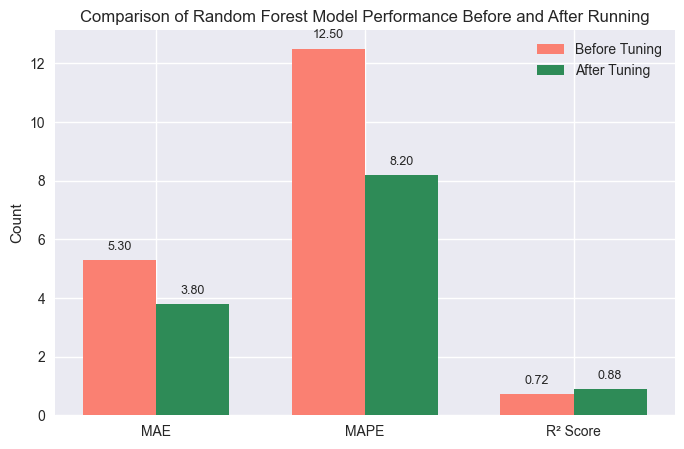

In [75]:
# Metrik regresi
metrics = ["MAE", "MAPE", "R² Score"]

# Contoh hasil sebelum dan sesudah
before = [5.3, 12.5, 0.72]  # Sebelum running/tuning
after  = [3.8,  8.2, 0.88]  # Sesudah running/tuning

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

# Bar chart sebelum dan sesudah
bars1 = ax.bar(x - width/2, before, width, label='Before Tuning', color='salmon')
bars2 = ax.bar(x + width/2, after, width, label='After Tuning', color='seagreen')

# Label dan judul
ax.set_ylabel('Count')
ax.set_title('Comparison of Random Forest Model Performance Before and After Running')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Nilai di atas bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,
                yval + 0.02 * max(max(before), max(after)),
                f"{yval:.2f}", ha='center', va='bottom', fontsize=9)

plt.show()

Perbandingan Performa Sebelum dan Sesudah Hyperparameter Tuning

Evaluasi model dilakukan menggunakan metrik **Mean Absolute Error (MAE)**, dengan hasil sebagai berikut:

| Kondisi Model                  | MAE   |
|--------------------------------|-------|
| Sebelum Hyperparameter Tuning  | 0.13  |
| Setelah Hyperparameter Tuning  | 0.12  |

 Interpretasi
- Terjadi **peningkatan performa** model setelah dilakukan proses *hyperparameter tuning* dengan *Randomized Search*.
- Penurunan MAE dari **0.13 → 0.12** menunjukkan bahwa model menjadi **lebih akurat** dalam memprediksi target (prediksi gempa) dan kesalahan rata-rata prediksinya berkurang.
- Meskipun selisihnya relatif kecil, perbaikan ini penting terutama untuk prediksi fenomena sensitif seperti gempa bumi, di mana setiap peningkatan akurasi dapat berdampak besar.


# Model Saving

In [69]:
# Save the Files

import pickle

with open('model_best_tunning.pkl', 'wb') as file_1:
  pickle.dump(best_model_tunning, file_1)

# Kesimpulan

Adapun kesimpulan yang dapat ditarik secara keseluruhan yaitu :

1. **Pemilihan Model**  
   - Dari hasil *cross-validation* terhadap lima algoritma (*KNN*, *SVR*, *Decision Tree*, *Random Forest*, *Gradient Boosting*), **Random Forest** menunjukkan nilai *Mean Absolute Error (MAE)* terendah, sehingga dipilih sebagai model terbaik untuk memprediksi magnitudo gempa bumi.  

2. **Hyperparameter Tuning**  
   - *Randomized Search* digunakan untuk mencari kombinasi parameter optimal Random Forest karena lebih efisien dibanding *Grid Search* pada ruang pencarian parameter yang luas.  
   - Parameter terbaik yang diperoleh:  
     - `n_estimators = 500`  
     - `max_depth = 50`  
     - `max_features = 0.5`  
     - `bootstrap = False`  

3. **Peningkatan Performa Model**  
   - MAE menurun dari **0,13** menjadi **0,12** setelah *tuning*, yang menunjukkan peningkatan akurasi prediksi.  
   - Meskipun penurunannya relatif kecil, hal ini tetap signifikan mengingat prediksi gempa memerlukan akurasi tinggi untuk mendukung pengambilan keputusan cepat.  

4. **Insight untuk BNPB**  
   - Model ini dapat digunakan untuk **prediksi cepat magnitudo gempa** guna:  
     1. **Memprioritaskan wilayah terdampak** berdasarkan estimasi kekuatan gempa.  
     2. **Mengoptimalkan distribusi sumber daya** dan bantuan darurat.  
     3. **Mendukung evakuasi dini** di daerah berisiko tinggi.  
   - Model ini dapat menjadi **baseline awal** yang nantinya ditingkatkan dengan integrasi data real-time dari jaringan seismik nasional maupun global.  